In [254]:
# Libray for Data Manipulation.
import pandas as pd
import numpy as np

#Library for Data Visualization.
import seaborn as sns 
import matplotlib.pyplot as plt
import altair as alt
import matplotlib.ticker as ticker
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

sns.set(style="white",font_scale=1.5)
sns.set(rc={"axes.facecolor":"#FFFAF0","figure.facecolor":"#FFFAF0"})
sns.set_context("poster",font_scale = .7)

# Library to overcome Warnings.
import warnings
warnings.filterwarnings('ignore')

# Library to perform Statistical Analysis.
from scipy import stats
from scipy.stats import chi2
from scipy.stats import chi2_contingency

# Library to Display whole Dataset.
pd.set_option("display.max.columns",None)

# pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

#Modeling
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_predict, GridSearchCV

# 1. Import the data

In [110]:
train = pd.read_csv('./Binary Classification with a Bank Churn Dataset/train.csv')
test = pd.read_csv('./Binary Classification with a Bank Churn Dataset/test.csv')

orign_data = pd.read_csv('./Binary Classification with a Bank Churn Dataset/Churn_Modelling.csv')

In [111]:
print("Train dataset shape: ",train.shape)
print("Test dataset shape: ",test.shape)

Train dataset shape:  (165034, 14)
Test dataset shape:  (110023, 13)


# 2. Data Cleaning

## 2.1 Missing Values

In [112]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


In [113]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110023 entries, 0 to 110022
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               110023 non-null  int64  
 1   CustomerId       110023 non-null  int64  
 2   Surname          110023 non-null  object 
 3   CreditScore      110023 non-null  int64  
 4   Geography        110023 non-null  object 
 5   Gender           110023 non-null  object 
 6   Age              110023 non-null  float64
 7   Tenure           110023 non-null  int64  
 8   Balance          110023 non-null  float64
 9   NumOfProducts    110023 non-null  int64  
 10  HasCrCard        110023 non-null  float64
 11  IsActiveMember   110023 non-null  float64
 12  EstimatedSalary  110023 non-null  float64
dtypes: float64(5), int64(5), object(3)
memory usage: 10.9+ MB


## 2.2 Dropping Attritbutes which doesn't imply any meaningful insights in our analysis

In [114]:
cols = ["id", "CustomerId", "Surname"]
train.drop(columns=cols, inplace=True)
test.drop(columns=cols, inplace=True)

## 2.3 Checking Duplicate Records

In [115]:
print("Duplicates in Train Dataset: ",train.duplicated().sum())

Duplicates in Train Dataset:  123


In [116]:
print("Duplicates in Test Dataset: ",test.duplicated().sum())

Duplicates in Test Dataset:  72


###### There are 571 duplicate records present in the Train dataset and 72 duplicate records present in the Test Dataset.

In [117]:
#Dropping Duplicates 
train = train.drop_duplicates()
test = test.drop_duplicates()

# 3. EDA

In [118]:
train.describe().T.style.background_gradient()

,count,mean,std,min,25%,50%,75%,max
CreditScore,164911.000000,656.468914,80.091065,350.000000,597.000000,659.000000,710.000000,850.000000
Age,164911.000000,38.124278,8.865020,18.000000,32.000000,37.000000,42.000000,92.000000
Tenure,164911.000000,5.020599,2.806237,0.000000,3.000000,5.000000,7.000000,10.000000
Balance,164911.000000,55481.138955,62819.233625,0.000000,0.000000,0.000000,119948.090000,250898.090000
NumOfProducts,164911.000000,1.554420,0.547171,1.000000,1.000000,2.000000,2.000000,4.000000
HasCrCard,164911.000000,0.753916,0.430730,0.000000,1.000000,1.000000,1.000000,1.000000
IsActiveMember,164911.000000,0.497693,0.499996,0.000000,0.000000,0.000000,1.000000,1.000000
EstimatedSalary,164911.000000,112579.798396,50290.229424,11.580000,74639.870000,117948.000000,155155.250000,199992.480000
Exited,164911.000000,0.211684,0.408503,0.000000,0.000000,0.000000,0.000000,1.000000


# 3.2 Target Variable Analysis
    How many people churned and how many didn't?

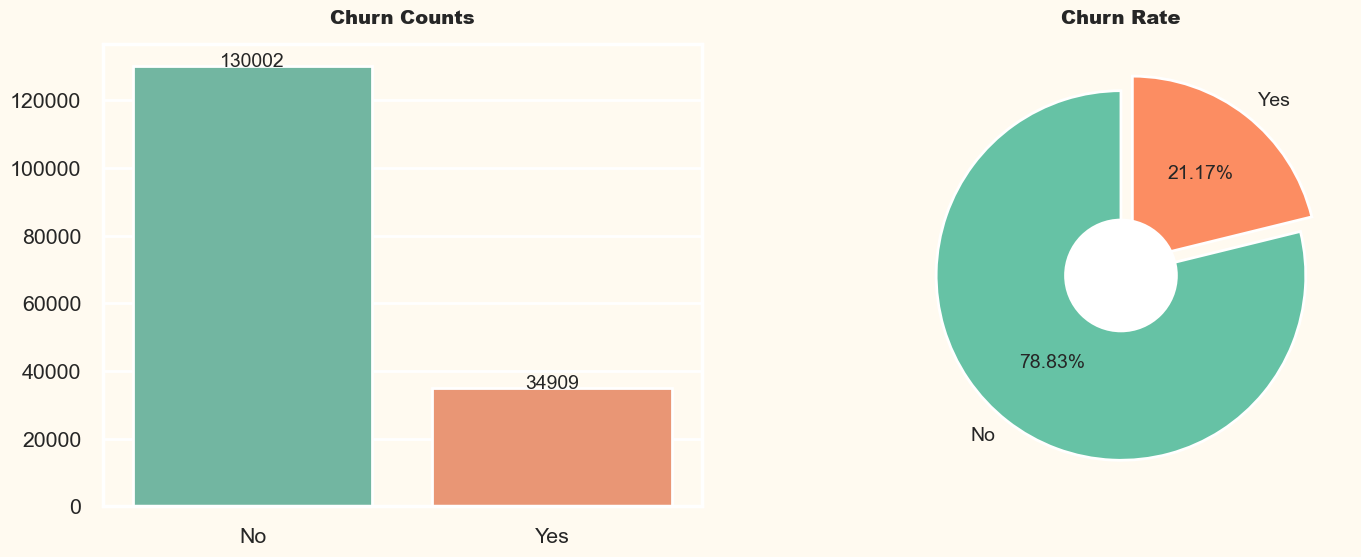

In [119]:
#Visualization to show Churn in Counts.
plt.figure(figsize=(17,6))
plt.subplot(1,2,1)
attrition_rate = train["Exited"].value_counts()
sns.barplot(x=["No","Yes"],y=attrition_rate.values,palette= 'Set2')
plt.title("Churn Counts",fontweight="black", size=14, pad=15)
for i, v in enumerate(attrition_rate.values):
    plt.text(i, v, v,ha="center", fontsize=14)

#Visualization to show Churn in Percentage.
plt.subplot(1,2,2)
colors = sns.color_palette('Set2', len(attrition_rate))
plt.pie(attrition_rate, labels=["No","Yes"], autopct="%.2f%%", textprops={"size":14},
        colors = colors,explode=[0,0.1],startangle=90)
center_circle = plt.Circle((0, 0), 0.3, fc='white')
fig = plt.gcf()
fig.gca().add_artist(center_circle)
plt.title("Churn Rate",fontweight="black",size=14 ,pad=15)
plt.show()

##### Some Observations from above plots:
     1.We can see that data is highly imbalanced. Almost 80% of our data is not exited and 20% data is exited.
     2.In a real life also we only care about the persons or the people who are quitting or leaving (Exited) the bank and we only want to analyse the patterns of those people.
    ...

## 3.3 Features Analysis

### 3.3.1 categorical Features

In our data categorical varibles are:

    Geography
    Gender
    Tenure
    NumOfProducts
    HasCrCard
    IsActiveMember

In [120]:
train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [121]:
def pie_bar_plot(df, col, attrition_col):
    plt.figure(figsize=(14, 6))
    
    # Extract value counts for the specified column
    value_counts = df[col].value_counts().sort_index()
    
    # First subplot: Pie chart
    plt.subplot(1, 2, 1) 
    ax1 = value_counts
    plt.title(f"Total Distribution by {col}", fontweight="black", size=14, pad=15)
    colors = sns.color_palette('Set2', len(ax1))
    plt.pie(ax1.values, labels=ax1.index, autopct="%.1f%%", pctdistance=0.75, startangle=90, 
            colors=colors, textprops={"size":14})
    center_circle = plt.Circle((0, 0), 0.4, fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(center_circle)
    
    # Second subplot: Bar plot
    plt.subplot(1, 2, 2)
    
    # Convert integer attrition column to 'Yes' and 'No'
    df['attrition_label'] = np.where(df[attrition_col] == 1, 'Yes', 'No')
    
    value_1 = value_counts
    value_2 = df[df['attrition_label'] == 'Yes'][col].value_counts().sort_index()
    
    ax2 = np.floor((value_2 / value_1) * 100).values
    sns.barplot(x=value_2.index, y=value_2.values, palette='Set2')
    plt.title(f"Attrition Total & Attrition Rate by {col}", fontweight="black", size=14, pad=15)
    
    for index, value in enumerate(value_2):
        plt.text(index, value, str(value) + " (" + str(int(ax2[index])) + "% )", ha="center", va="bottom", size=10)

    plt.tight_layout()
    plt.show()

# Example usage:
# pie_bar_plot(your_dataframe, 'some_column', 'attrition'

In [122]:
def count_percent_plot(df, col, attrition_col):

    plt.figure(figsize=(13.5, 8))
    plt.subplot(1, 2, 1)
    value_1 = df[col].value_counts()
    sns.barplot(x=value_1.index, y=value_1.values, order=value_1.index, palette='Set2')
    plt.title(f"Total & Percent by {col}", fontweight="black", size=14, pad=15)
    for index, value in enumerate(value_1.values):
        count_percentage = "{:.1f}%".format((value / len(df)) * 100)
        plt.text(index, value, f"{value} ({count_percentage})", ha="center", va="bottom", size=10)
    plt.xticks(rotation=90)

    # Convert integer attrition column to 'Yes' and 'No'
    df['attrition_label'] = np.where(df[attrition_col] == 1, 'Yes', 'No')

    # Sort the values for the second subplot to match the order of the first subplot
    value_2 = df[df['attrition_label'] == 'Yes'][col].value_counts().reindex(value_1.index)

    plt.subplot(1, 2, 2)
    attrition_rate = (value_2 / value_1 * 100).values
    sns.barplot(x=value_2.index, y=value_2.values, order=value_1.index, palette='Set2')
    plt.title(f"Attrition Total & Attrition Rate by {col}", fontweight="black", size=14, pad=15)
    for index, value in enumerate(value_2.values):
        attrition_percentage = "{:.1f}%".format(np.round(attrition_rate[index], 1))
        plt.text(index, value, f"{value} ({attrition_percentage})", ha="center", va="bottom", size=10)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

## 3.3.1.1 Geography

In [123]:
train[['Geography','Exited']].groupby(['Geography']).mean().reset_index().sort_values(by='Exited', ascending=False)


,Geography,Exited
1,Germany,0.378928
2,Spain,0.172220
0,France,0.165406


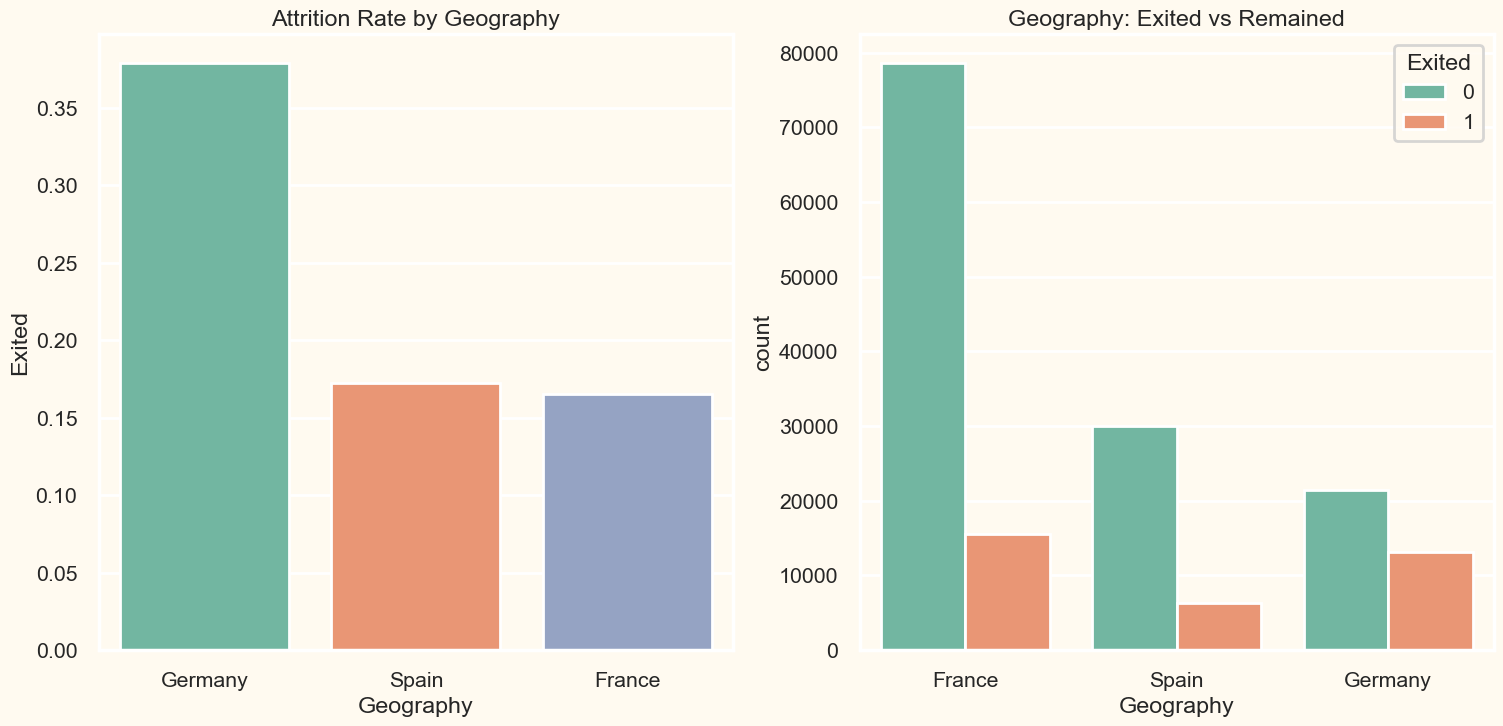

In [124]:
f,ax=plt.subplots(1,2,figsize=(18,8))
# train[['Geography','Exited']].groupby(['Geography']).mean().plot.bar(ax=ax[0]) # 每个地方的流失率
grouped = train[['Geography','Exited']].groupby(['Geography']).mean().reset_index().sort_values(by='Exited', ascending=False)
sns.barplot(x='Geography',y ='Exited',data=grouped,ax=ax[0], palette='Set2')
ax[0].set_title('Attrition Rate by Geography')
sns.countplot(x = 'Geography',hue='Exited',data=train,ax=ax[1], palette='Set2')
ax[1].set_title('Geography: Exited vs Remained')
plt.show()

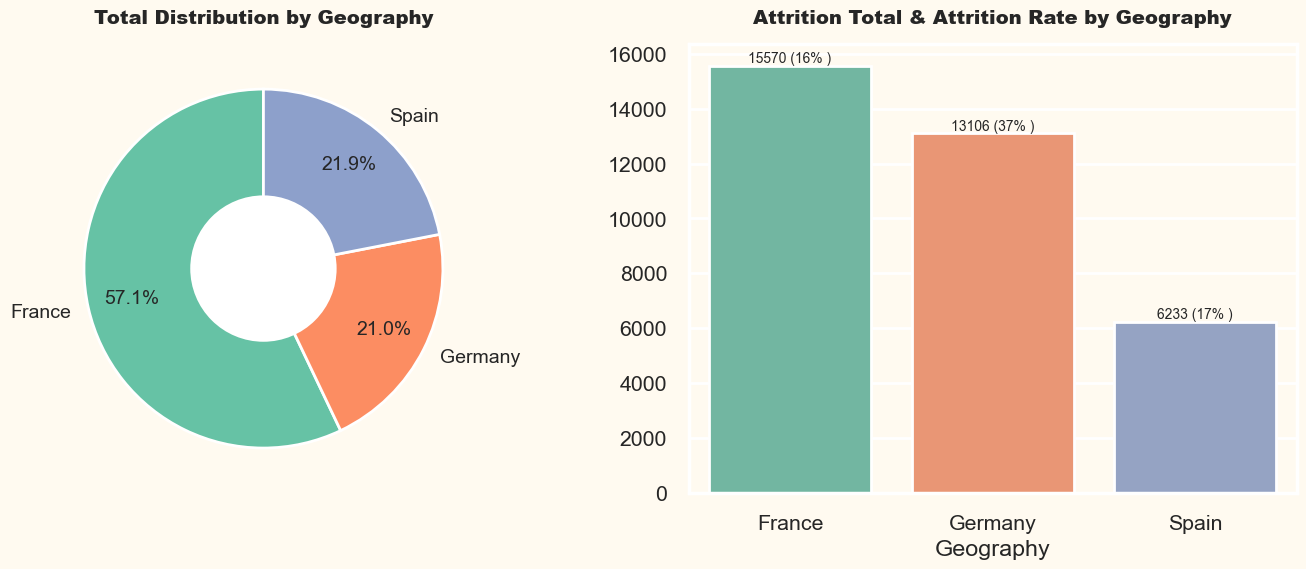

In [125]:
pie_bar_plot(train, 'Geography', 'Exited')

##### Some Observations from above plots:

    1.Most of the customers are from France i.e 57.1 % .
    2.The attrition rate is very high of customers who are from Germany.
    3.The attrition rate is low for customers who are from France.    
    ...

## 3.3.1.2 Gender

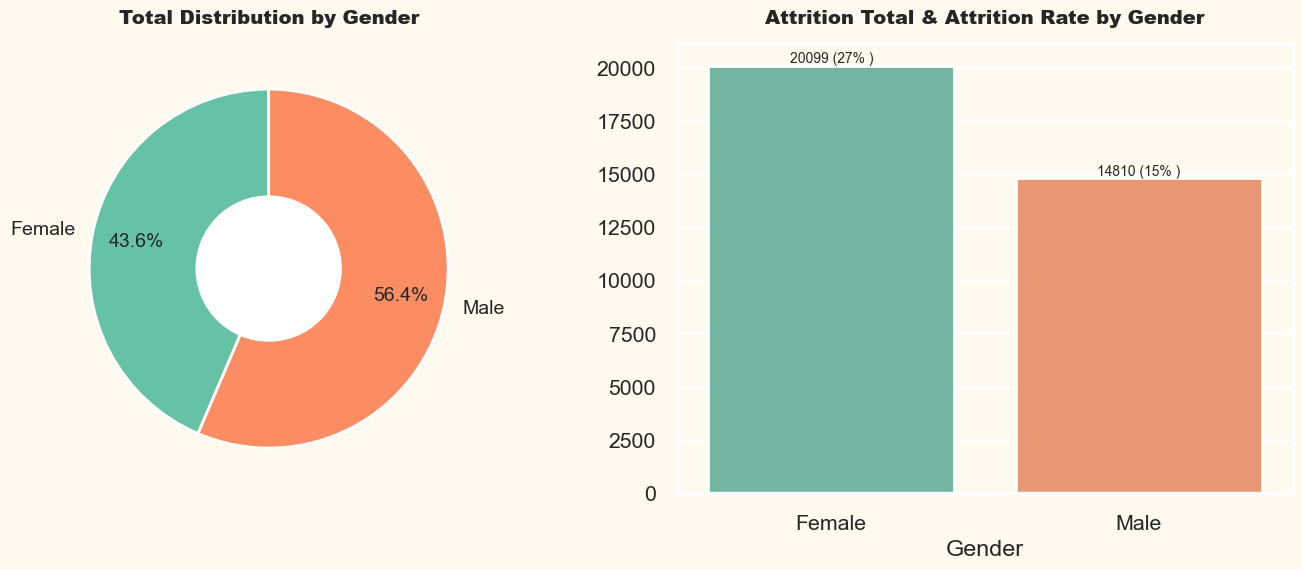

In [126]:
pie_bar_plot(train, 'Gender', 'Exited')

##### Some Observations from above plots:

    xxxx

### 3.3.1.3 Tenure

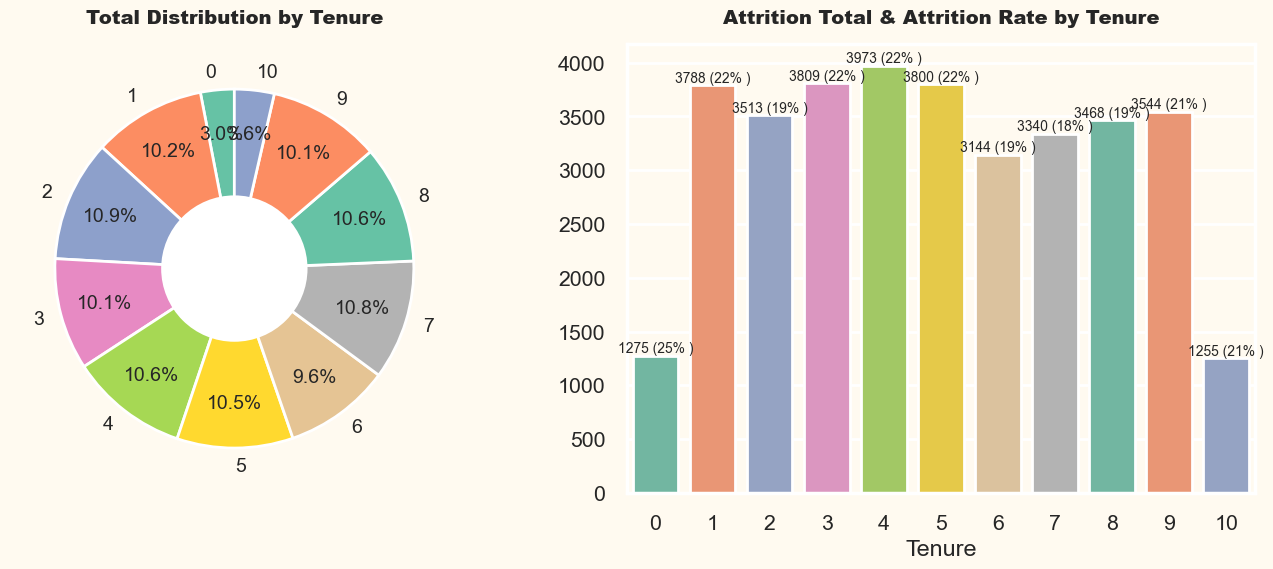

In [127]:
pie_bar_plot(train, 'Tenure', 'Exited')

(0.0, 1.0)

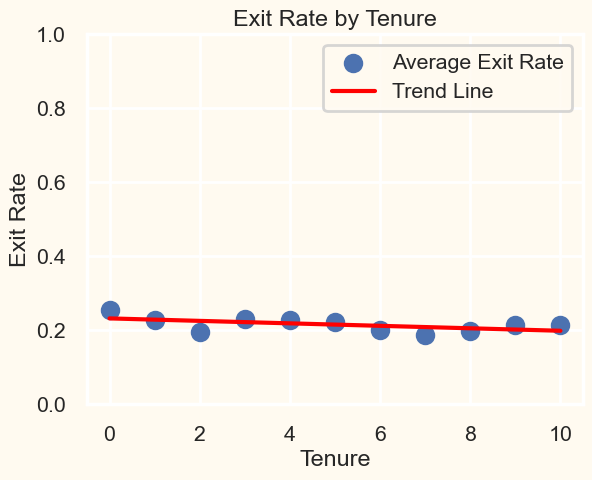

In [243]:
from sklearn.linear_model import LinearRegression, LogisticRegression

grouped = train[['Tenure','Exited']].groupby(['Tenure']).mean().reset_index()
plt.scatter(grouped['Tenure'], grouped['Exited'], label='Average Exit Rate')
X = grouped[['Tenure']].values.reshape(-1, 1)
y = grouped['Exited'].values
model = LinearRegression()
model.fit(X, y)
predicted_y = model.predict(X)
plt.plot(grouped['Tenure'], predicted_y, label='Trend Line', color='red')
plt.title('Exit Rate by Tenure')
plt.xlabel('Tenure')
plt.ylabel('Exit Rate')
plt.legend()
plt.grid(True)
plt.ylim(0, 1)

##### Some Observations from above plots:

    xxxx

### 3.3.1.4 NumOfProducts

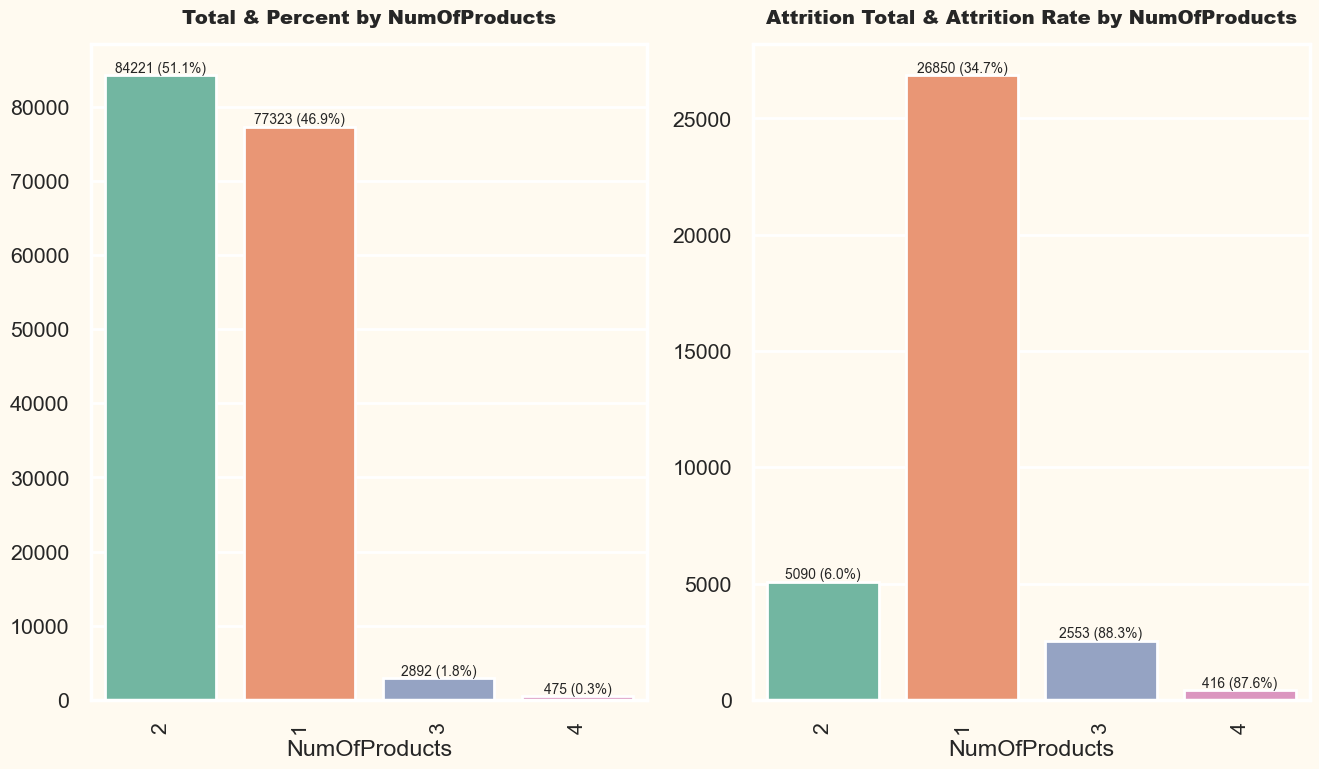

In [129]:
count_percent_plot(train,'NumOfProducts','Exited')

##### Some Observations from above plots:

    xxxx

### 3.3.1.5 HasCrCard

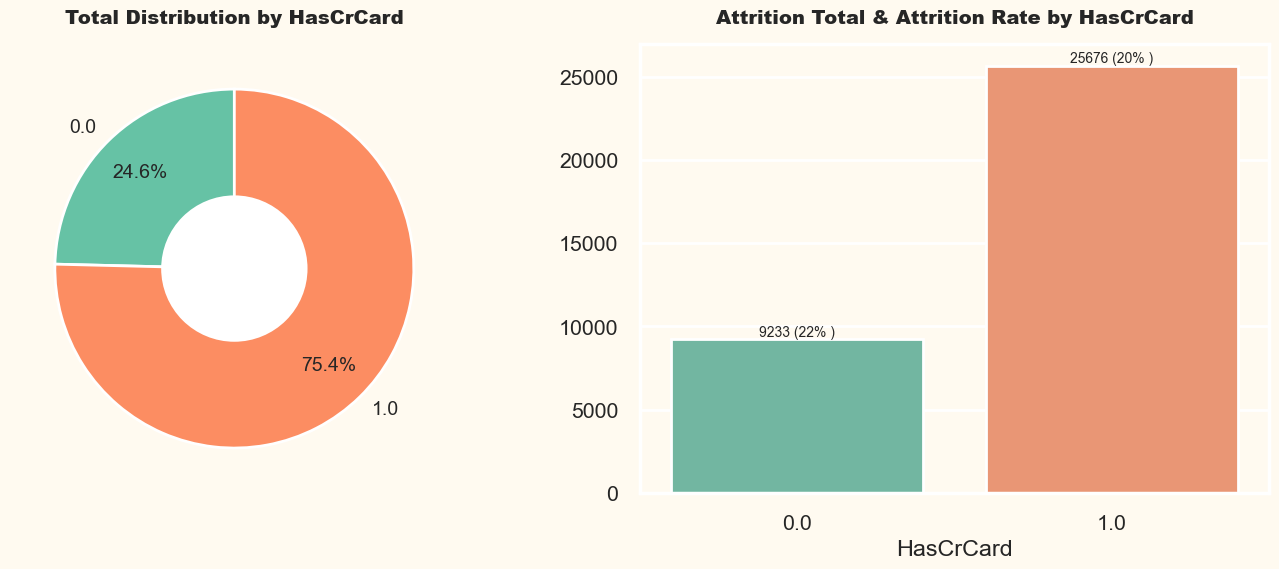

In [130]:
pie_bar_plot(train,'HasCrCard','Exited')

##### Some Observations from above plots:

    xxxx

### 3.3.1.6  IsActiveMember

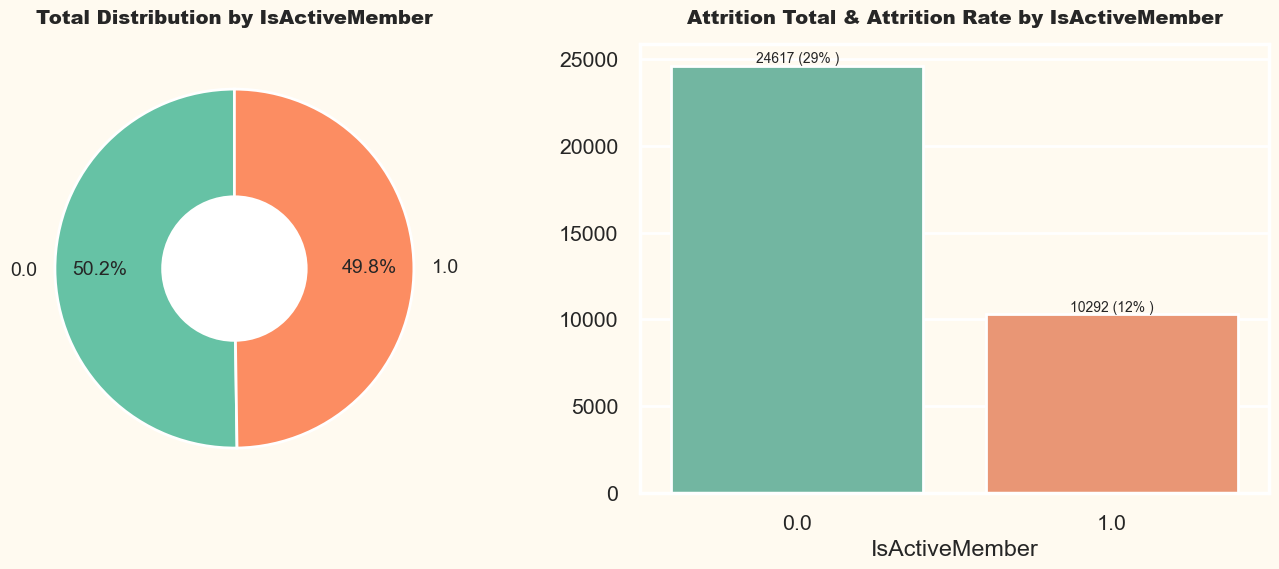

In [131]:
pie_bar_plot(train, 'IsActiveMember', 'Exited')

##### Some Observations from above plots:

    xxxx

### 3.3.2 Numerical Value Analysis

In Mathematics, if a variable can take on two or more distinct real values so that it can also take all real values between them (even values that are randomly close together). In this case, the variable is continuous in the given interval. Continuous data is the statistical data type consisting of continuous variables or of data that has been converted into that form.
    
In our data Continuous variables are:
    
    CreditScore
    Age
    Balance
    EstimatedSalary

In [132]:
def hist_with_hue(df, col, attrition_col):
    plt.figure(figsize=(13.5, 6))
    
    # Convert integer attrition column to 'Yes' and 'No'
    df['attrition_label'] = np.where(df[attrition_col] == 1, 'Yes', 'No')
    
    plt.subplot(1, 2, 1)
    sns.histplot(x=col, hue='attrition_label', data=df, kde=True, palette='Set2')
    
    # Configure the x-axis to display integer values and center-align the labels
    ax = plt.gca()
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    plt.xticks(rotation=90, position=(0.5, 0), ha='center')  # Rotate x-axis labels by 90 degrees and center-align
    
    plt.title(f"Distribution by {col}", fontweight="black", size=14, pad=10)

    plt.subplot(1, 2, 2)
    sns.boxplot(x='attrition_label', y=col, data=df, palette='Set2')
    plt.title(f"Distribution by {col} & {attrition_col}", fontweight="black", size=14, pad=10)
    
    plt.tight_layout()
    plt.show()

#### 3.3.2.1 CreditScore

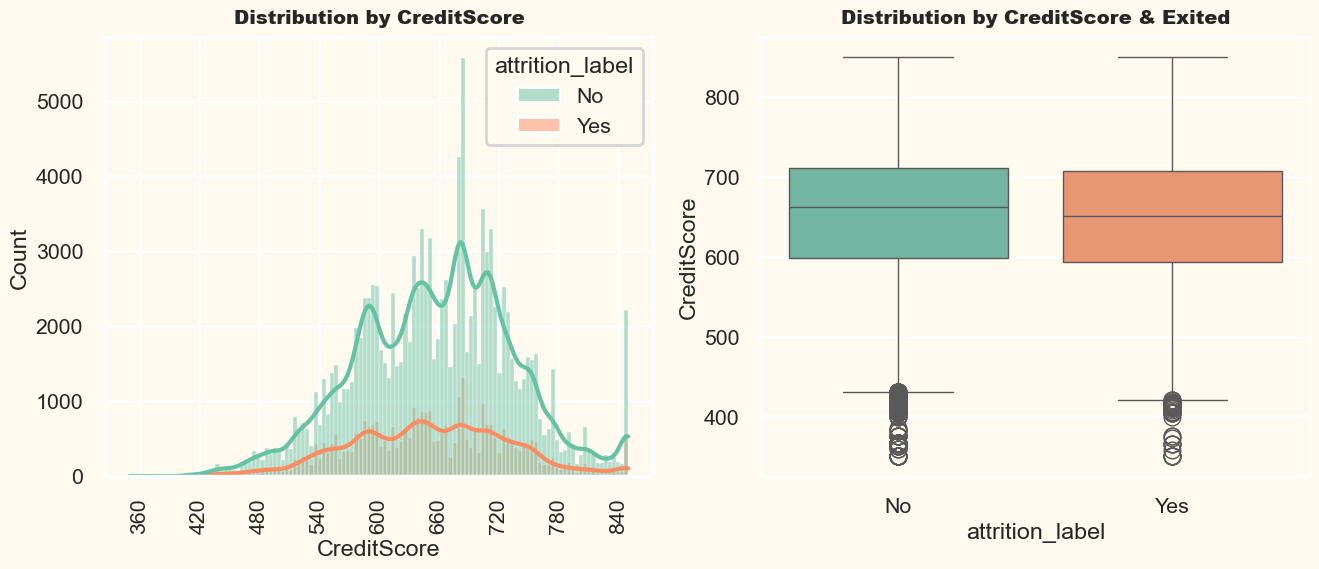

In [133]:
hist_with_hue(train, 'CreditScore', 'Exited')

##### Some Observations from above plots:

    xxxx

#### 3.3.2.2 Age

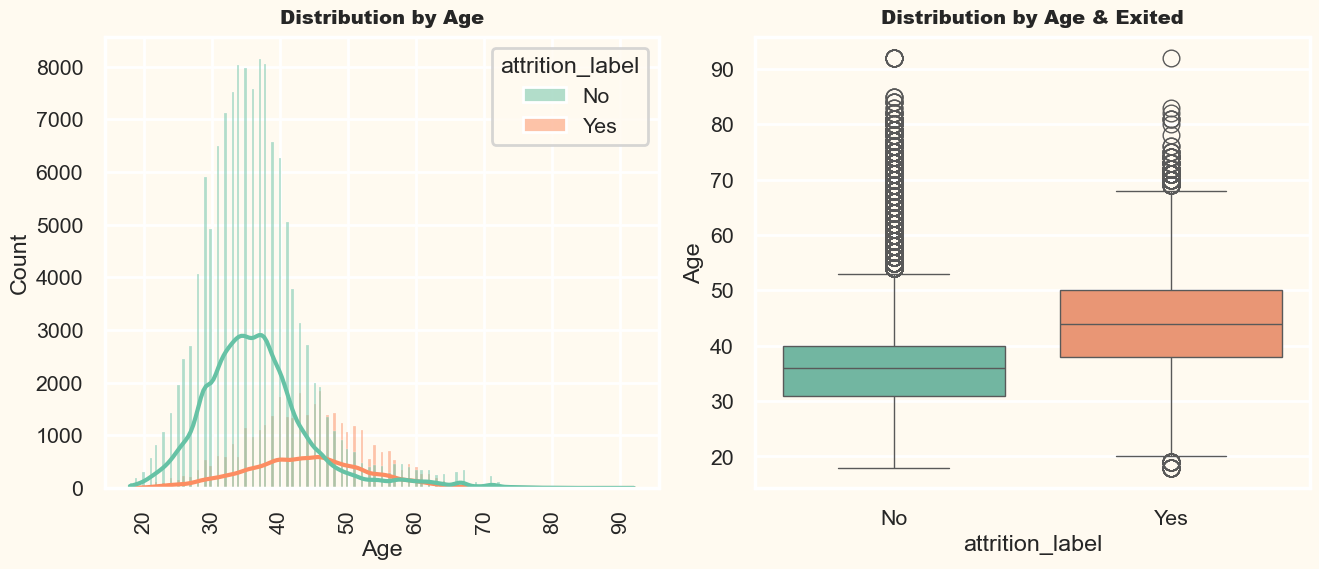

In [134]:
hist_with_hue(train, 'Age', 'Exited')

#### 3.3.2.3 Balance

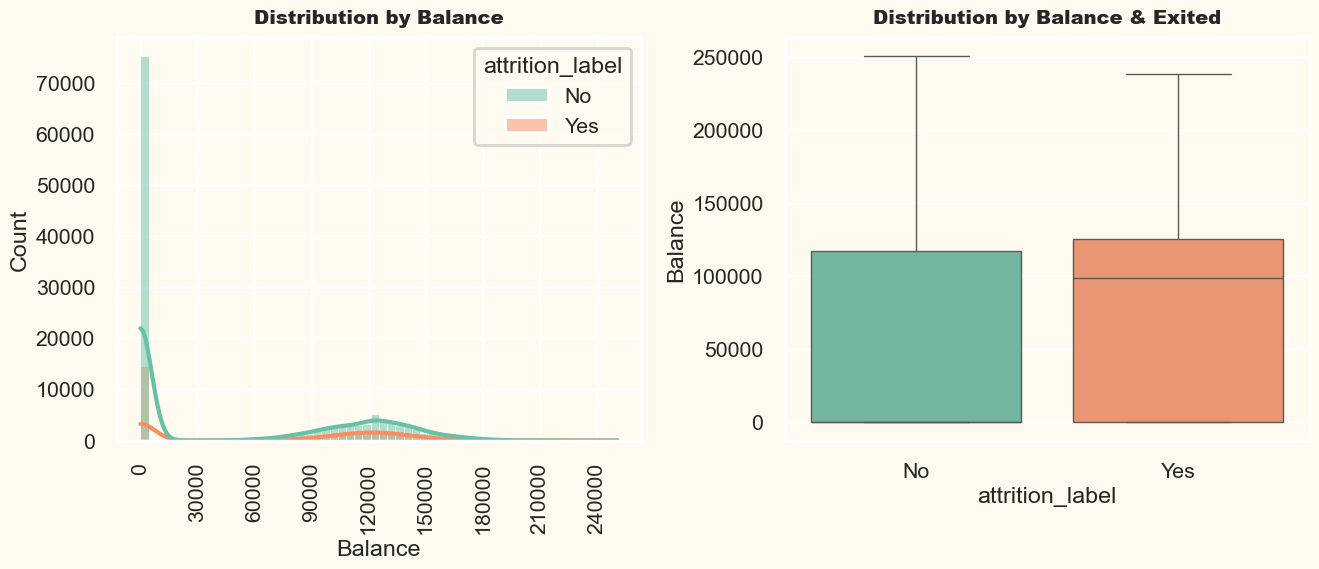

In [135]:
hist_with_hue(train, 'Balance', 'Exited')

#### 3.3.2.4 EstimatedSalary

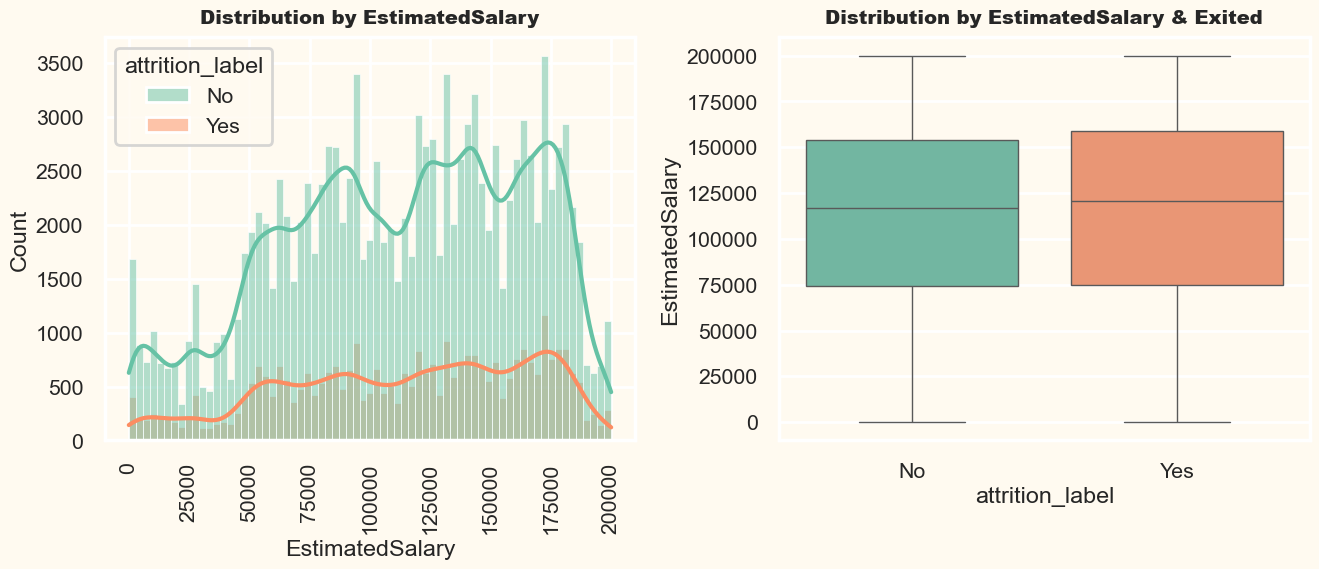

In [136]:
hist_with_hue(train, 'EstimatedSalary', 'Exited')

##### Some Observations from above plots:

    xxxx

In [137]:
train.drop(columns=['attrition_label'], inplace=True)

# 4. Encoding

In [138]:
train["Gender"] = train["Gender"].replace({"Female":0 ,"Male":1})
test["Gender"] = test["Gender"].replace({"Female":0 ,"Male":1})

In [168]:
# Using pandas get_dummies for one-hot encoding
train_encoded = pd.get_dummies(train, columns=['Geography'], prefix='geo')
test_encoded = pd.get_dummies(test, columns=['Geography'], prefix='geo')

In [169]:
# Convert specific boolean columns to integer (1 and 0)
columns_to_convert = ['geo_France', 'geo_Germany', 'geo_Spain']
train_encoded[columns_to_convert] = train_encoded[columns_to_convert].astype(int)
test_encoded[columns_to_convert] = test_encoded[columns_to_convert].astype(int)

# 5. Correlation Matrix

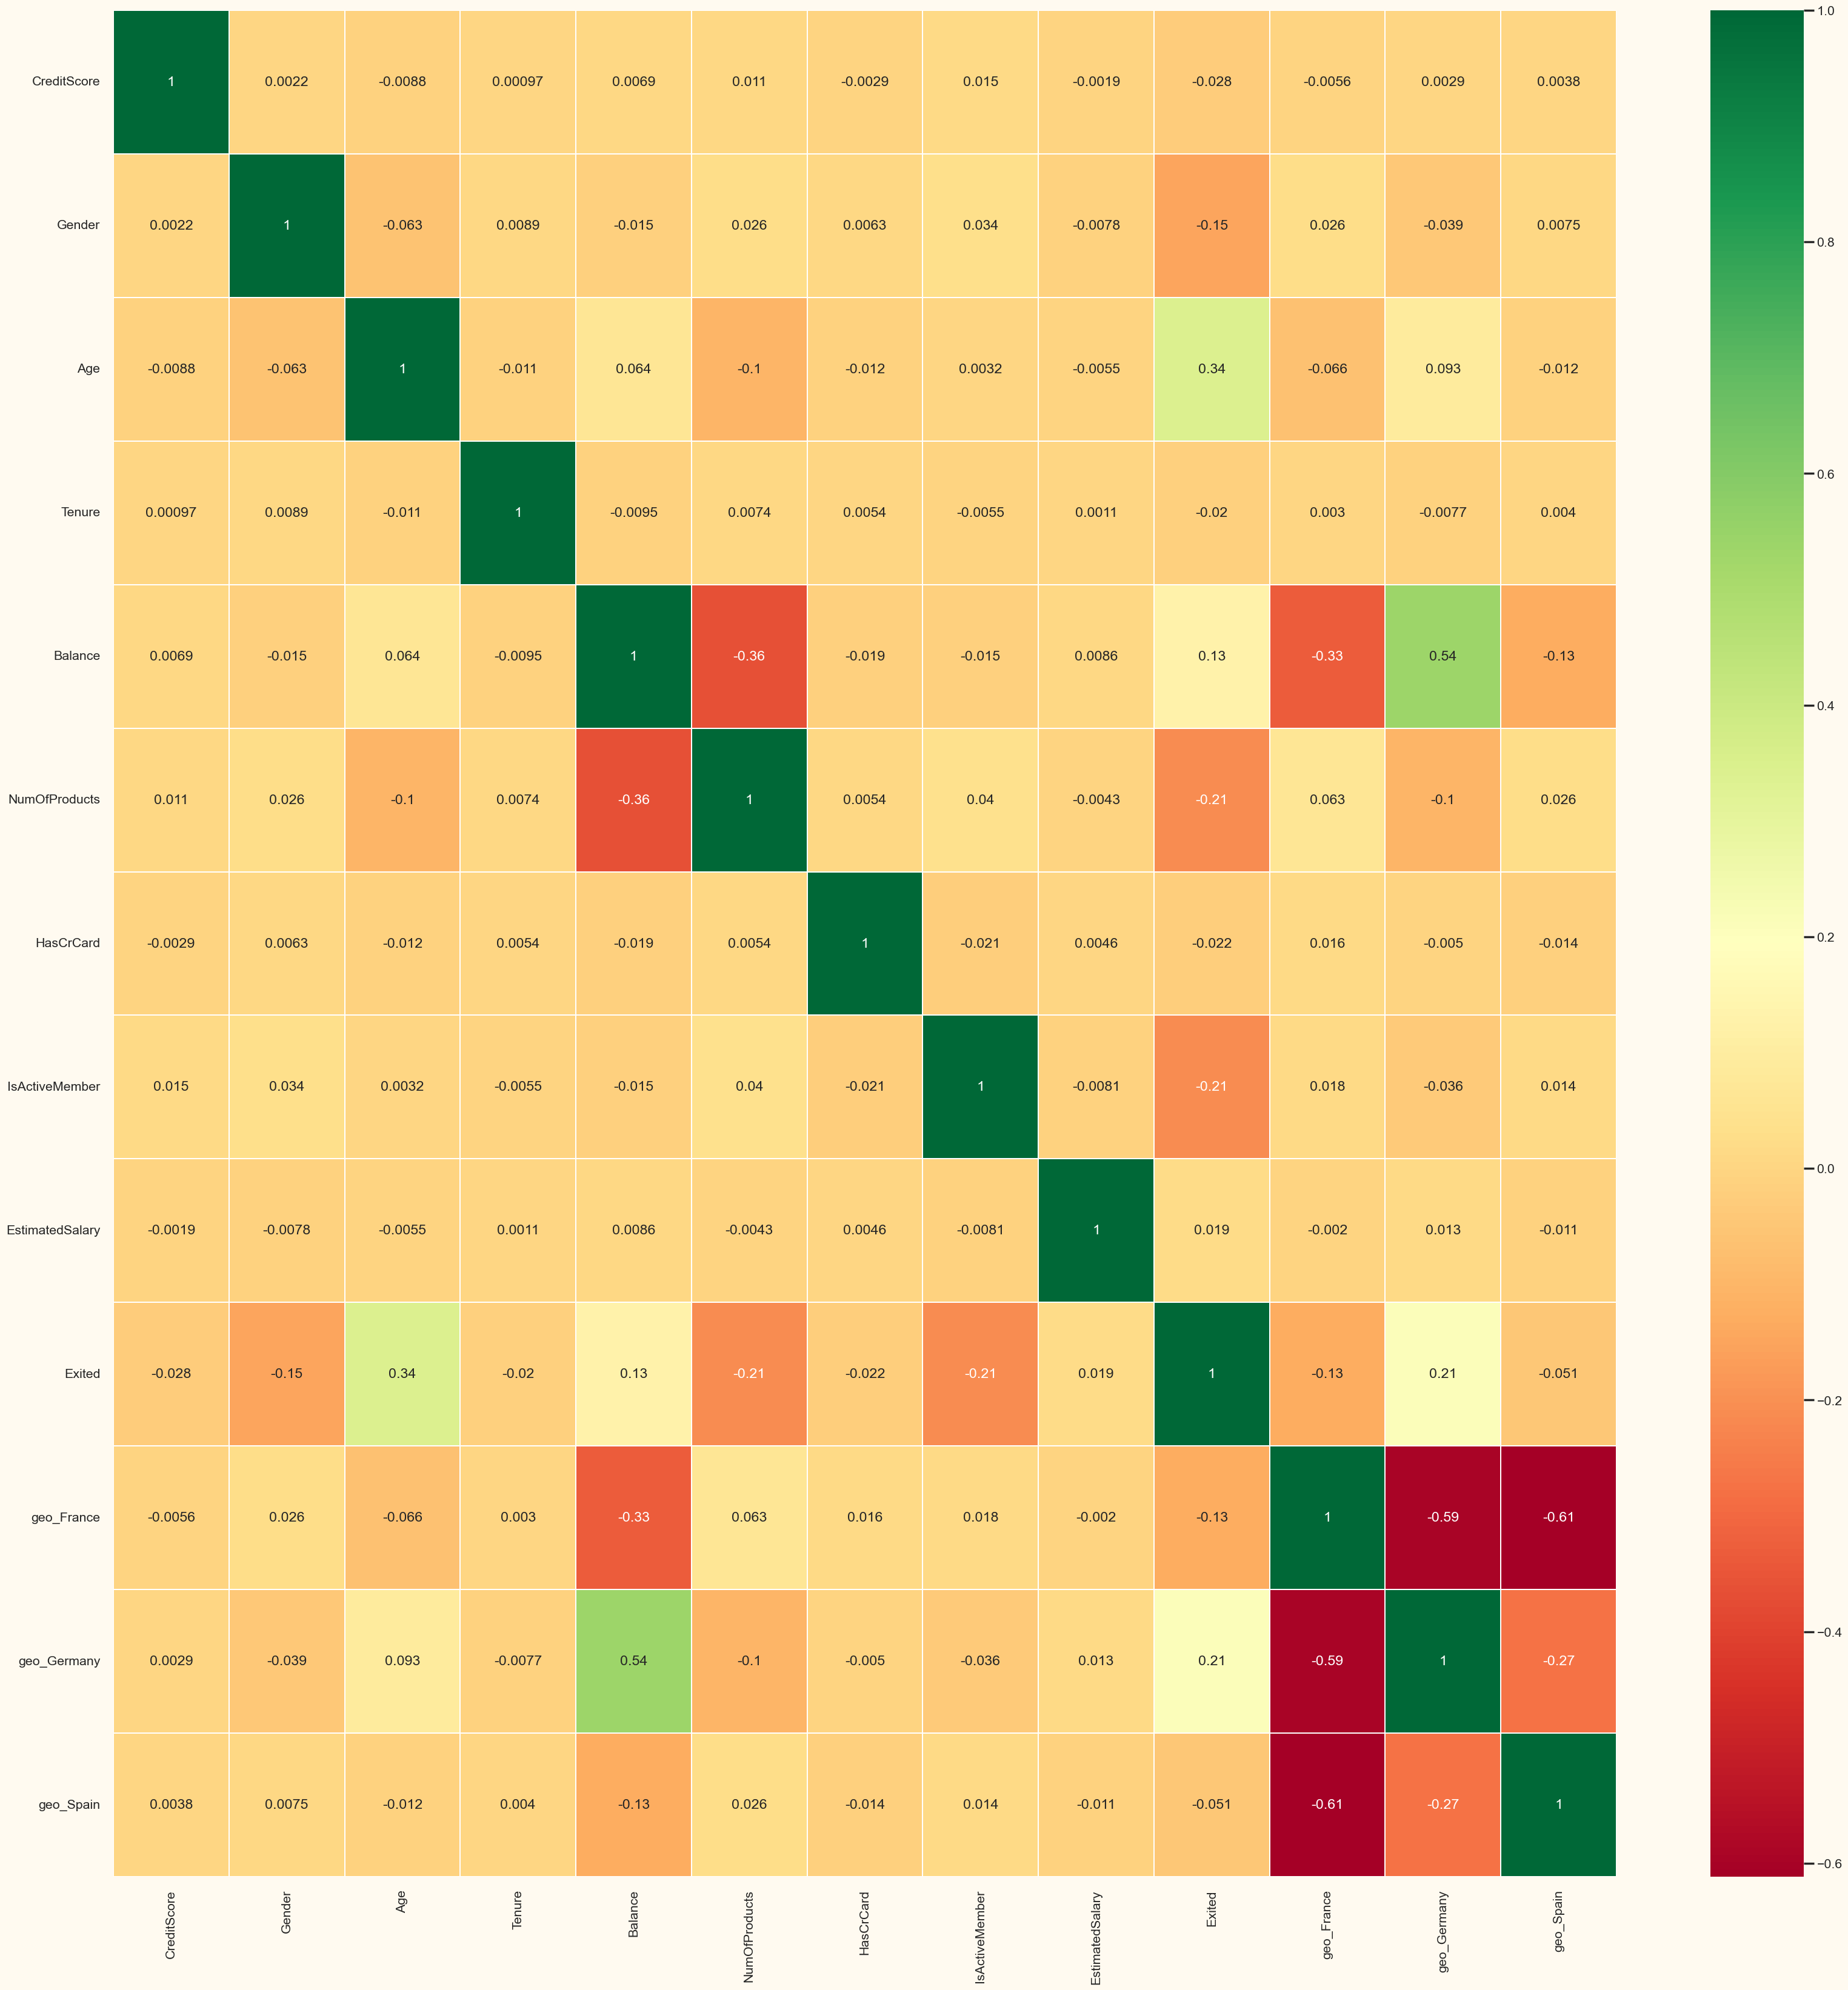

In [75]:
sns.heatmap(train_encoded.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(40,40)
plt.show()

##### Observations:

    no highly correlated features found


# 6. Dealing with Imbalanced Dataset

#### 6.1 Resampling - SOMTE

In [192]:
X_train_encoded = train_encoded.drop(['Exited'], axis=1)
y_train_encoded = train_encoded['Exited']

In [193]:
import imblearn
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X_train_encoded, y_train_encoded)
print("Before Smoote" , y.value_counts())
print("After Smoote" , y_smote.value_counts())

Before Smoote Exited
0    130002
1     34909
Name: count, dtype: int64
After Smoote Exited
0    130002
1    130002
Name: count, dtype: int64


In [200]:
X_smote.shape

(260004, 15)

In [201]:
y_smote.shape

(260004,)

### 6.2 XGBoost

# 7. Featutre Engineering

In [170]:
train_encoded.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,geo_France,geo_Germany,geo_Spain
0,668,1,33.0,3,0.00,2,1.0,0.0,181449.97,0,1,0,0
1,627,1,33.0,1,0.00,2,1.0,1.0,49503.50,0,1,0,0
2,678,1,40.0,10,0.00,2,1.0,0.0,184866.69,0,1,0,0
3,581,1,34.0,2,148882.54,1,1.0,1.0,84560.88,0,1,0,0
4,716,1,33.0,5,0.00,2,1.0,1.0,15068.83,0,0,0,1


In [171]:
test_encoded.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,geo_France,geo_Germany,geo_Spain
0,586,0,23.0,2,0.00,2,0.0,1.0,160976.75,1,0,0
1,683,0,46.0,2,0.00,1,1.0,0.0,72549.27,1,0,0
2,656,0,34.0,7,0.00,2,1.0,0.0,138882.09,1,0,0
3,681,1,36.0,8,0.00,1,1.0,0.0,113931.57,1,0,0
4,752,1,38.0,10,121263.62,1,1.0,0.0,139431.00,0,1,0


In [174]:
train_fe = train_encoded
test_fe = test_encoded

## 7.1 Age_band
Problem With Age Feature:
As I have mentioned earlier that Age is a continous feature, there is a problem with Continous Variables in Machine Learning Models.

Eg:If I say to group or arrange Sports Person by Sex, We can easily segregate them by Male and Female.

Now if I say to group them by their Age, then how would you do it? If there are 30 Persons, there may be 30 age values. Now this is problematic.

We need to convert these continous values into categorical values by either Binning or Normalisation. I will be using binning i.e group a range of ages into a single bin or assign them a single value.

Okay so Ages in the data range from 18 to 92. Let's set the age interval to 20 to make a better distinction.

##### Nonresampling

In [175]:
train_fe['Age_band']= np.round(train_fe.Age/20).astype('int')
test_fe['Age_band']= np.round(test_fe.Age/20).astype('int')

##### SOMTE

In [202]:
X_smote['Age_band']= np.round(X_smote.Age/20).astype('int')

## 7.2 IsSenior

As we know customers over 50 years of age are in the minority. Customers with elder age are more likely to churn compared to young employees. 
So we can do labels on whether the age is greater than 50 or not

##### Nonresampling

In [176]:
train_fe['IsSenior'] = train_fe['Age'].apply(lambda x: 1 if x >= 50 else 0)
test_fe['IsSenior'] = test_fe['Age'].apply(lambda x: 1 if x >= 50 else 0)

##### SOMTE

In [203]:
X_smote['IsSenior']= X_smote['Age'].apply(lambda x: 1 if x >= 50 else 0)

## 7.3 IsActive_HasCreditCard

We found in our previous explorations that active customers or those with credit cards are usually more likely to stay, so let's construct a feature with interactions

##### Nonresampling

In [177]:
train_fe['IsActive_HasCreditCard'] = train_fe['HasCrCard'] * train_fe['IsActiveMember']
test_fe['IsActive_HasCreditCard'] = test_fe['HasCrCard'] * test_fe['IsActiveMember']

##### SOMTE

In [204]:
X_smote['IsActive_HasCreditCard']= X_smote['HasCrCard'] * X_smote['IsActiveMember']

In [184]:
train_fe.shape

(164911, 16)

In [186]:
test_fe.shape

(109951, 15)

In [205]:
X_smote.shape

(260004, 15)

# 8.Feature Scaling

In [22]:
def outlier_filter(df):
    for column in df.columns: 
        print(column)
        
        # Calculate Q1  and Q3 
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        
        # Calculate IQR 
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        print(f"Lower bound for outliers: {lower_bound}")
        print(f"Upper bound for outliers: {upper_bound}")
        
        # Get the total number of outliers
        outlier_count = (df[column] < lower_bound) | (df[column] > upper_bound)
        total_outliers = outlier_count.sum()
        
        print(f"Total number of outliers: {total_outliers}")
        print("__________________")

In [88]:
outlier_filter(train_fe)

CreditScore
Lower bound for outliers: 427.5
Upper bound for outliers: 879.5
Total number of outliers: 252
__________________
Gender
Lower bound for outliers: -1.5
Upper bound for outliers: 2.5
Total number of outliers: 0
__________________
Age
Lower bound for outliers: 17.0
Upper bound for outliers: 57.0
Total number of outliers: 6382
__________________
Tenure
Lower bound for outliers: -3.0
Upper bound for outliers: 13.0
Total number of outliers: 0
__________________
Balance
Lower bound for outliers: -179922.135
Upper bound for outliers: 299870.225
Total number of outliers: 0
__________________
NumOfProducts
Lower bound for outliers: -0.5
Upper bound for outliers: 3.5
Total number of outliers: 475
__________________
HasCrCard
Lower bound for outliers: 1.0
Upper bound for outliers: 1.0
Total number of outliers: 40582
__________________
IsActiveMember
Lower bound for outliers: -1.5
Upper bound for outliers: 2.5
Total number of outliers: 0
__________________
EstimatedSalary
Lower bound fo

#### # Plotting data distributions and box plots for each feature

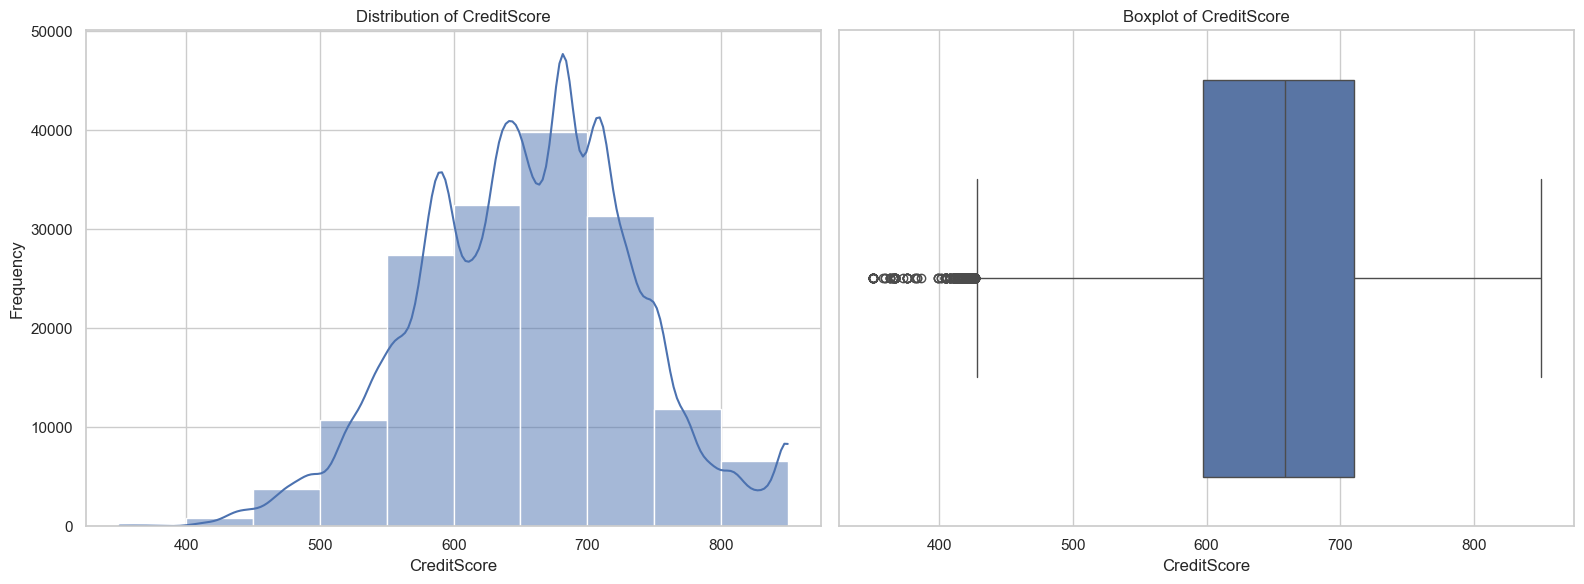

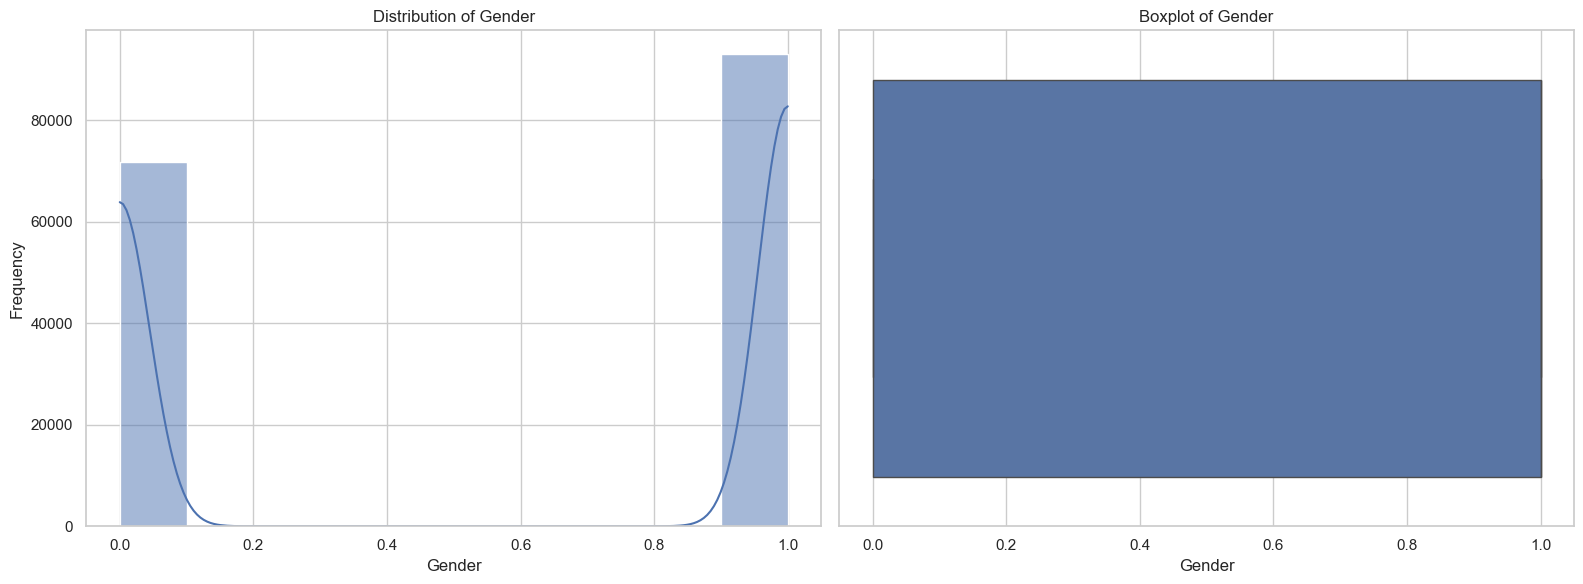

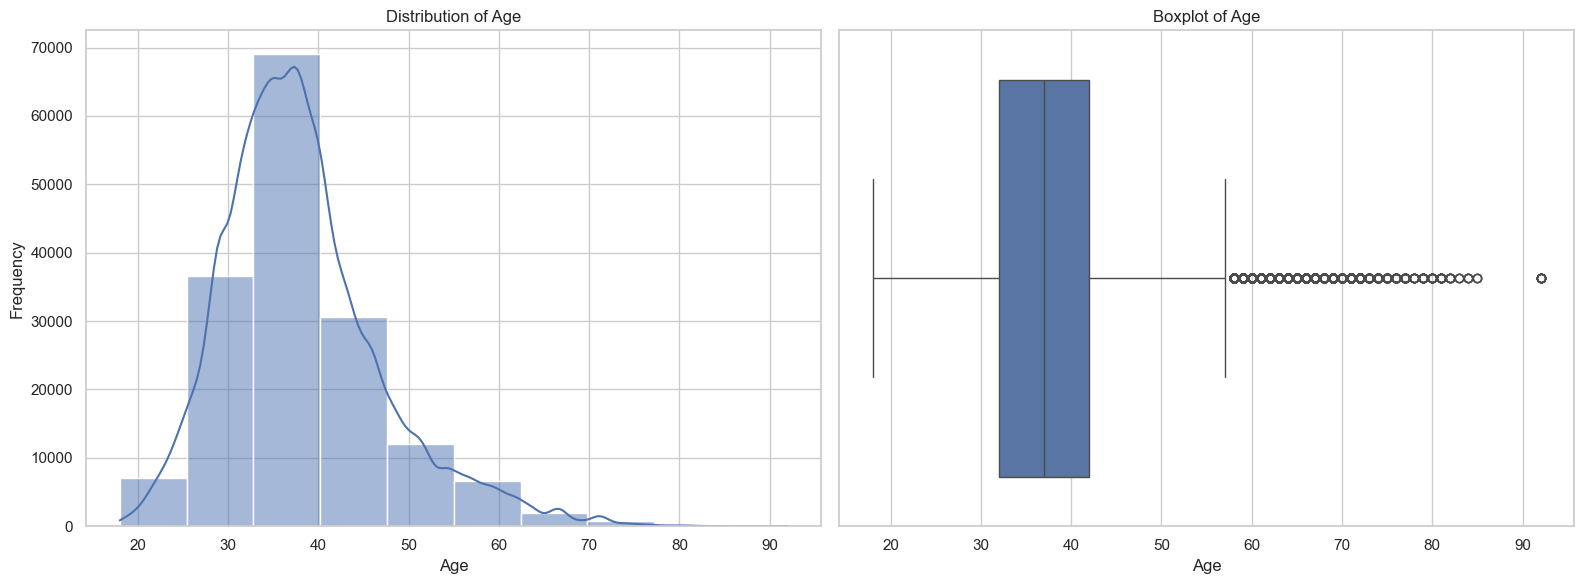

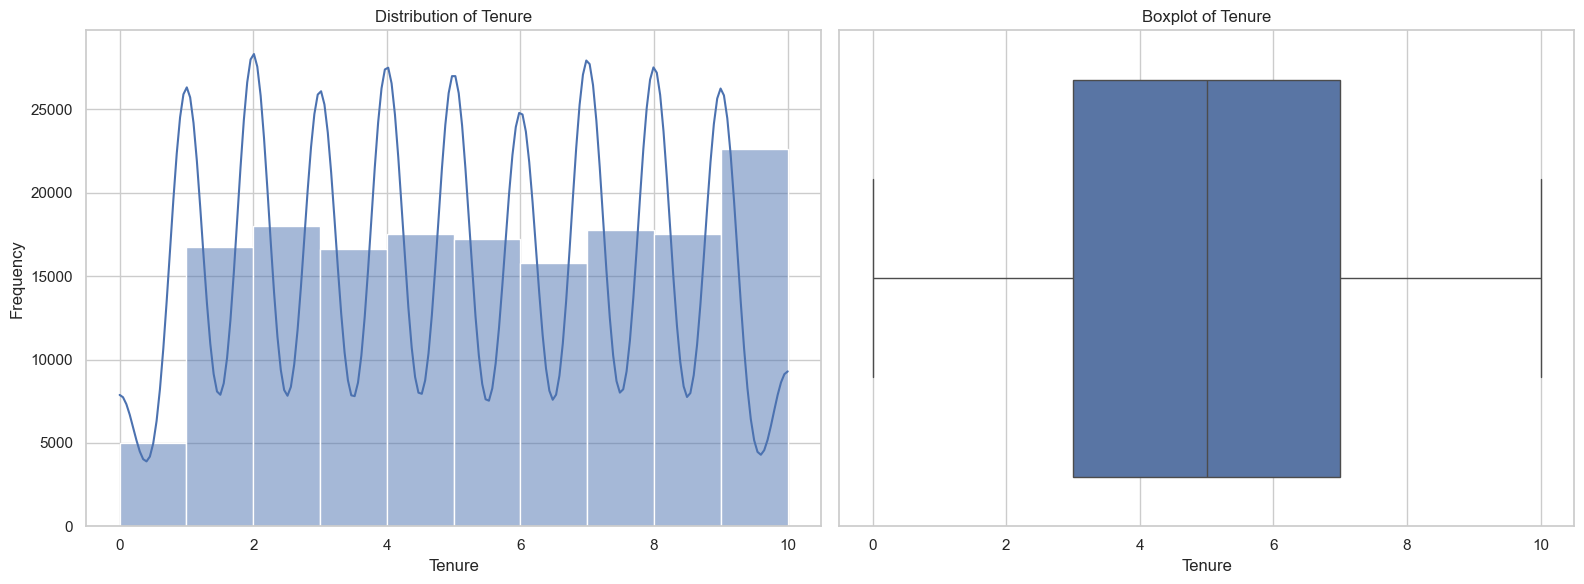

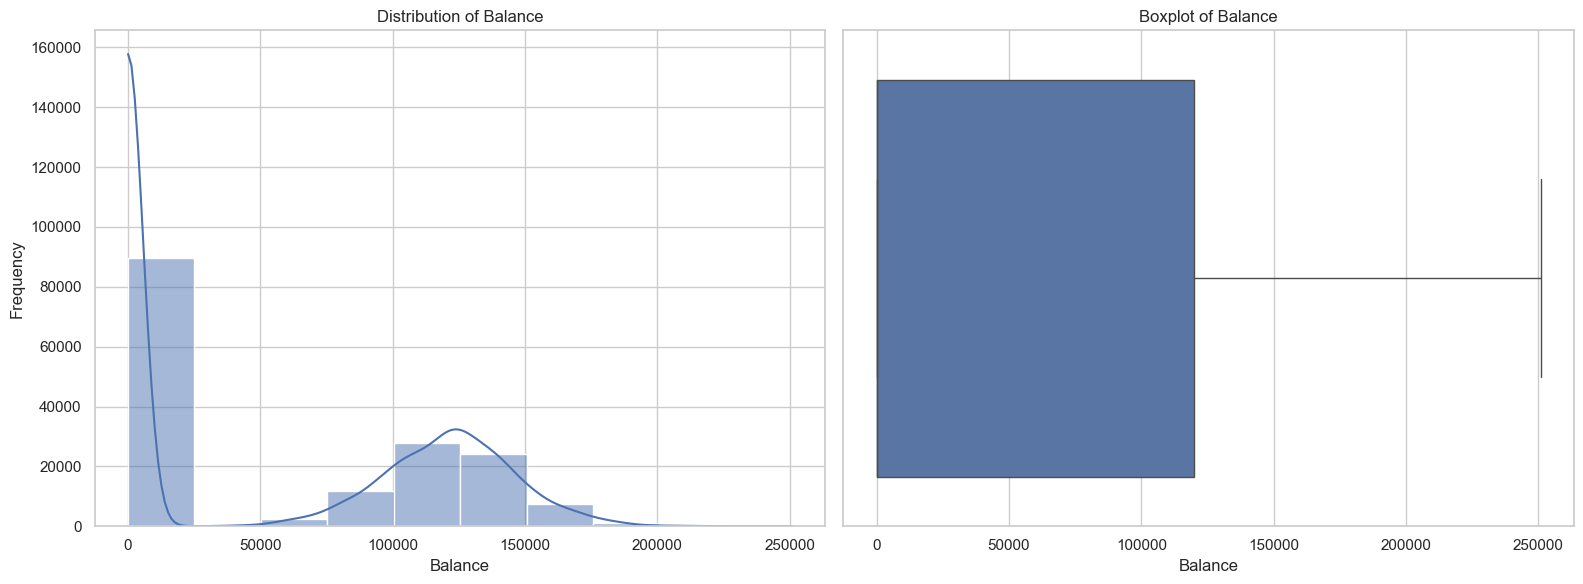

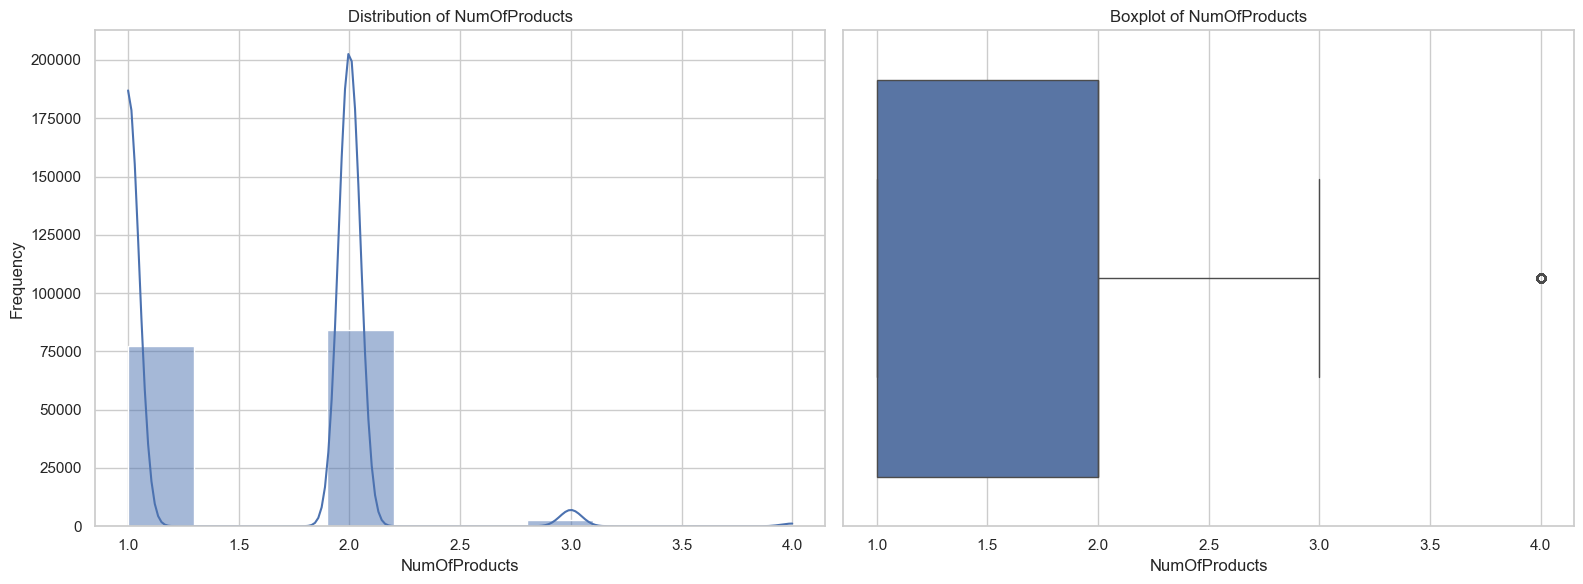

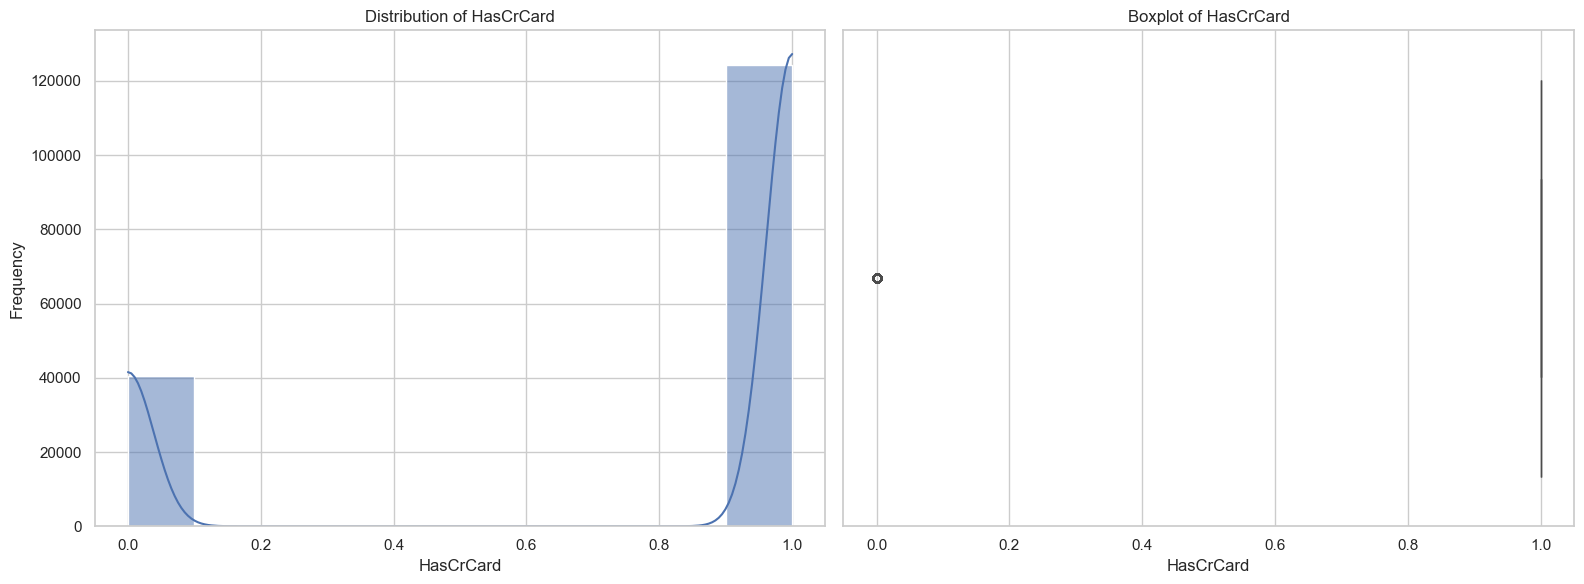

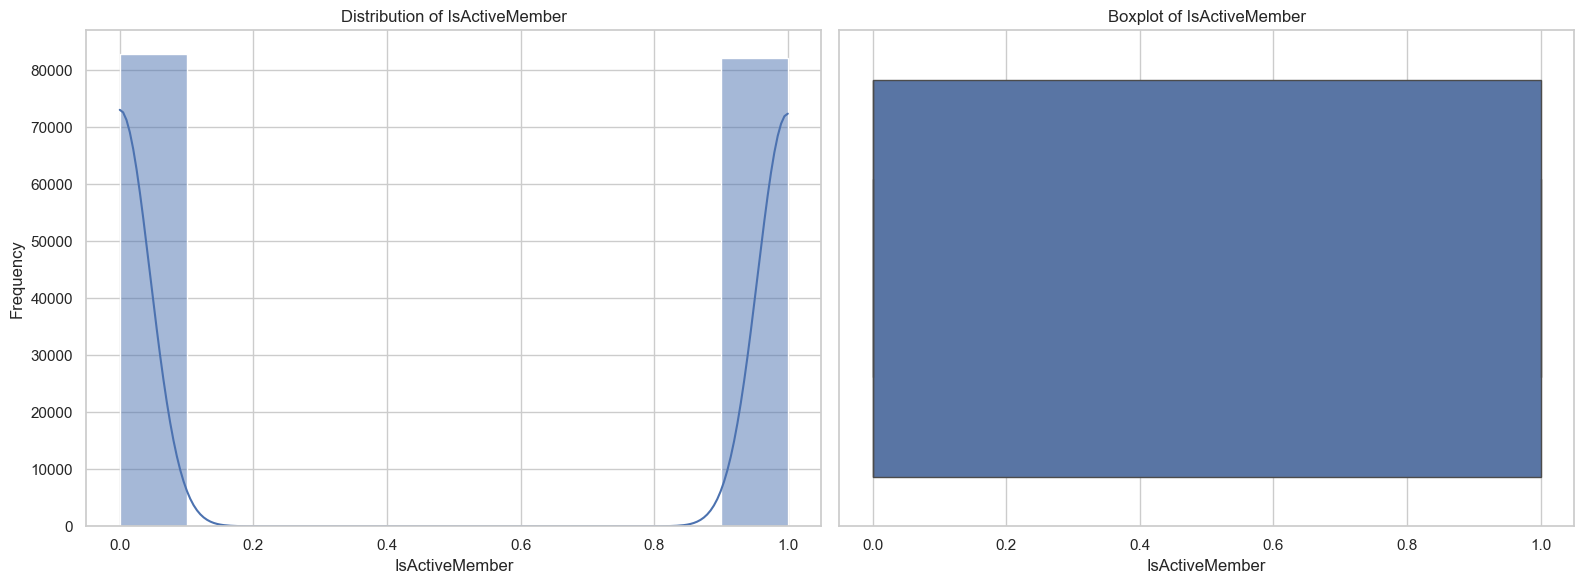

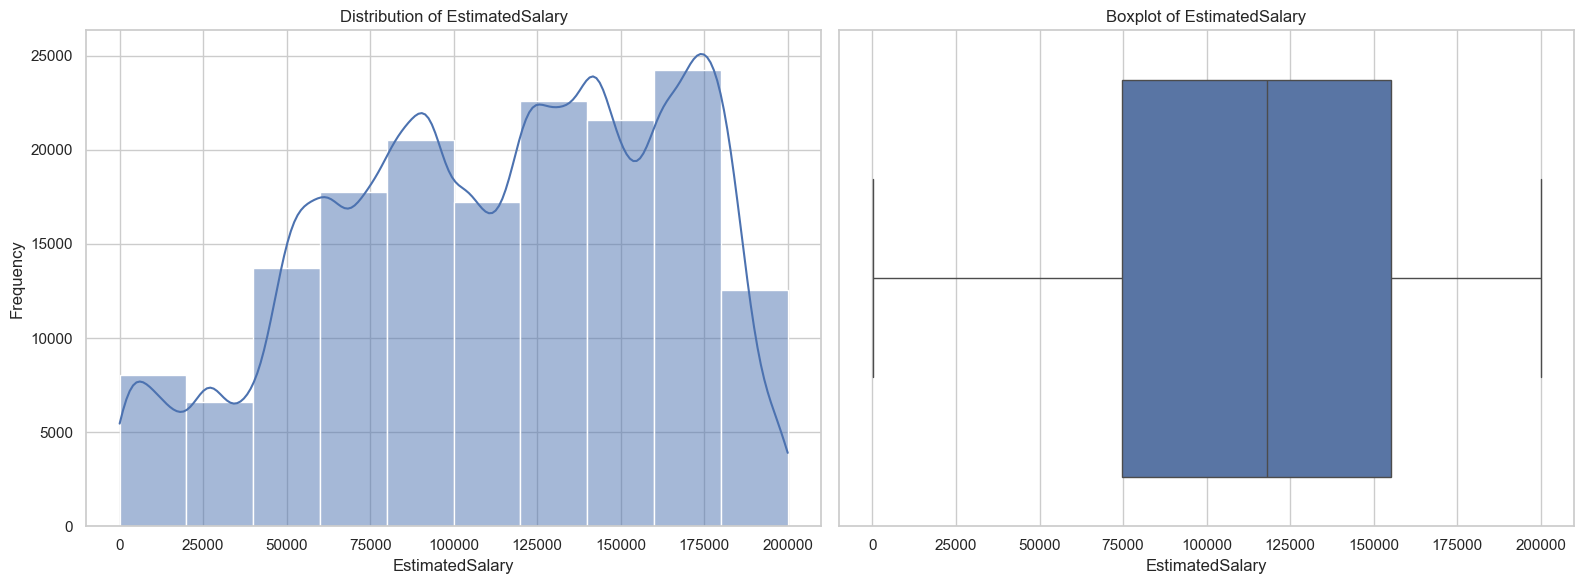

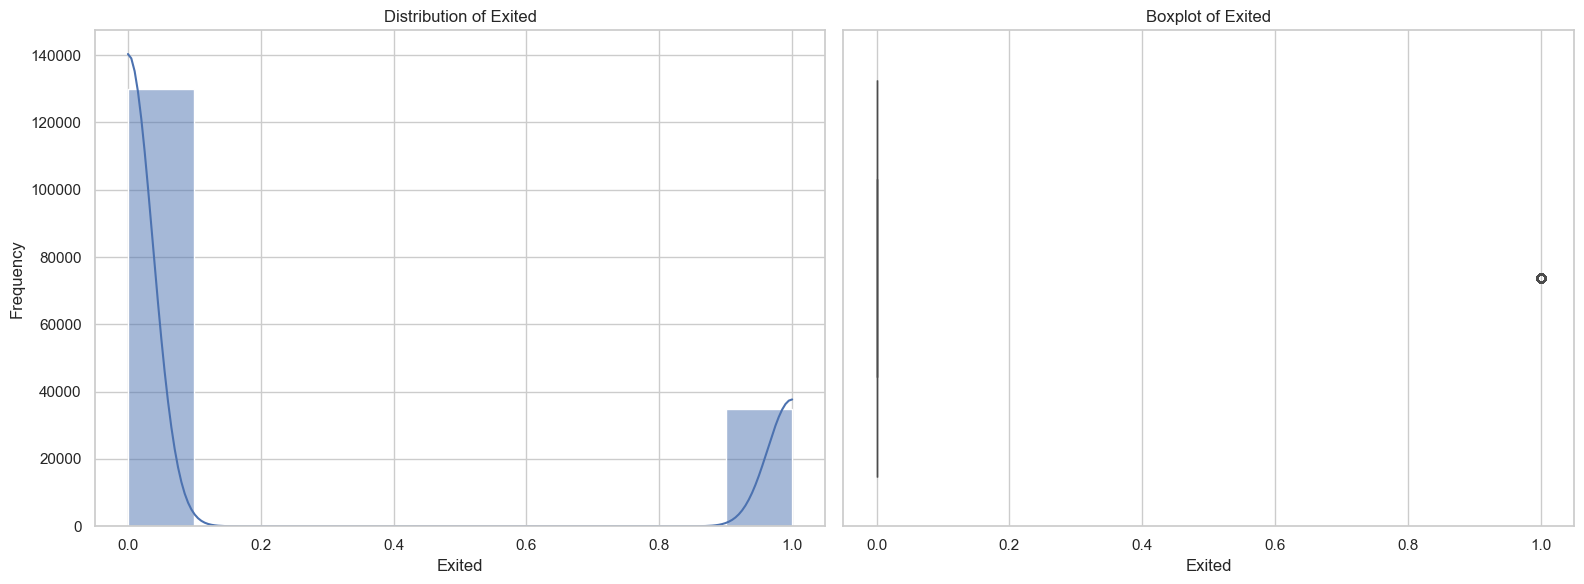

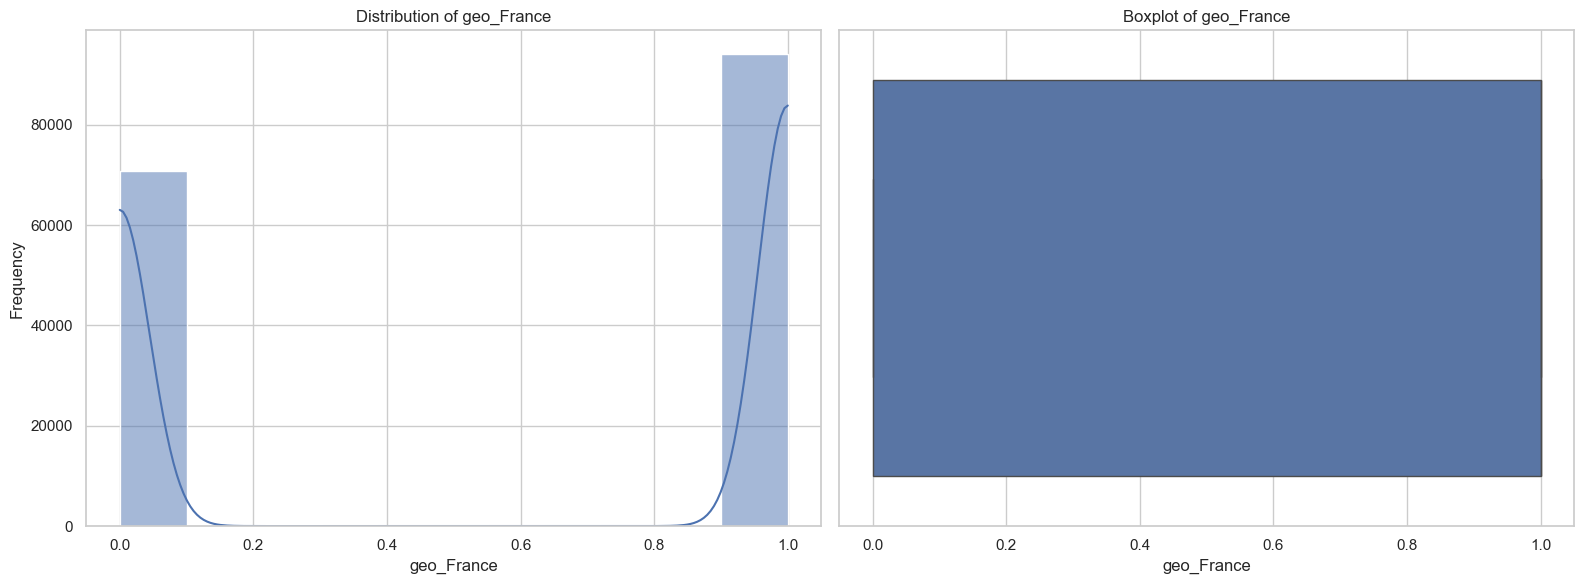

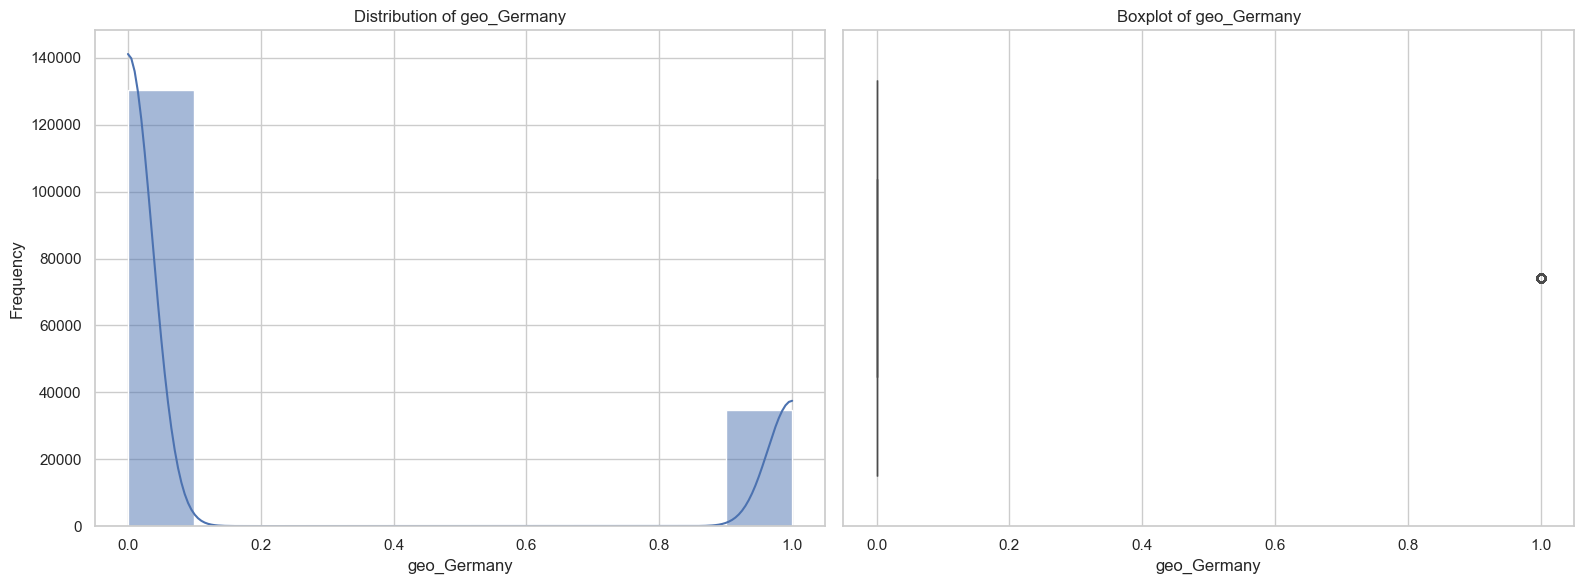

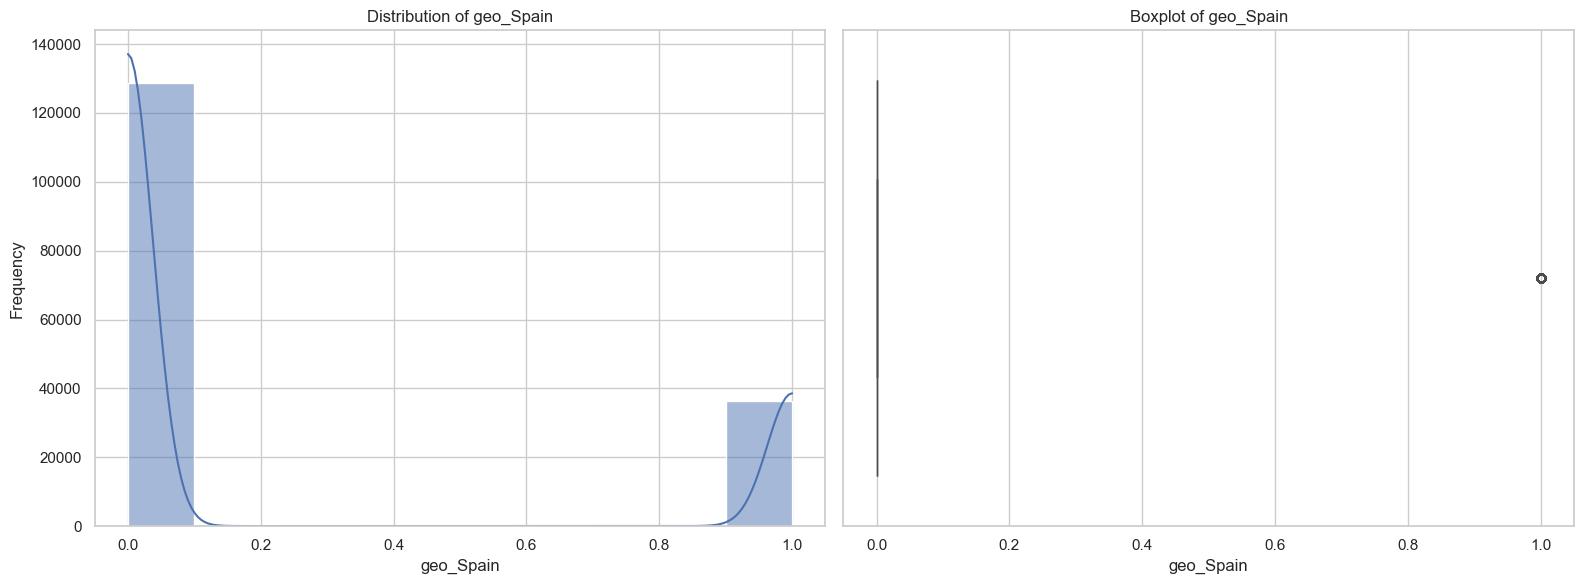

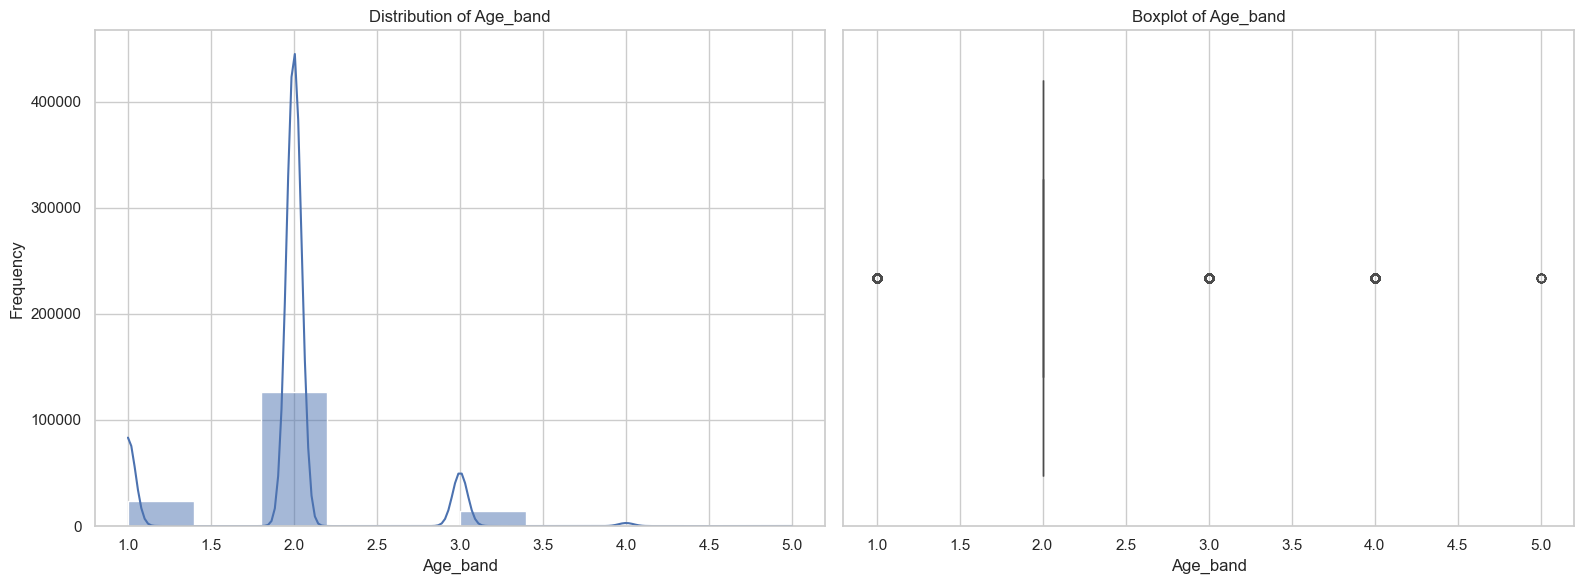

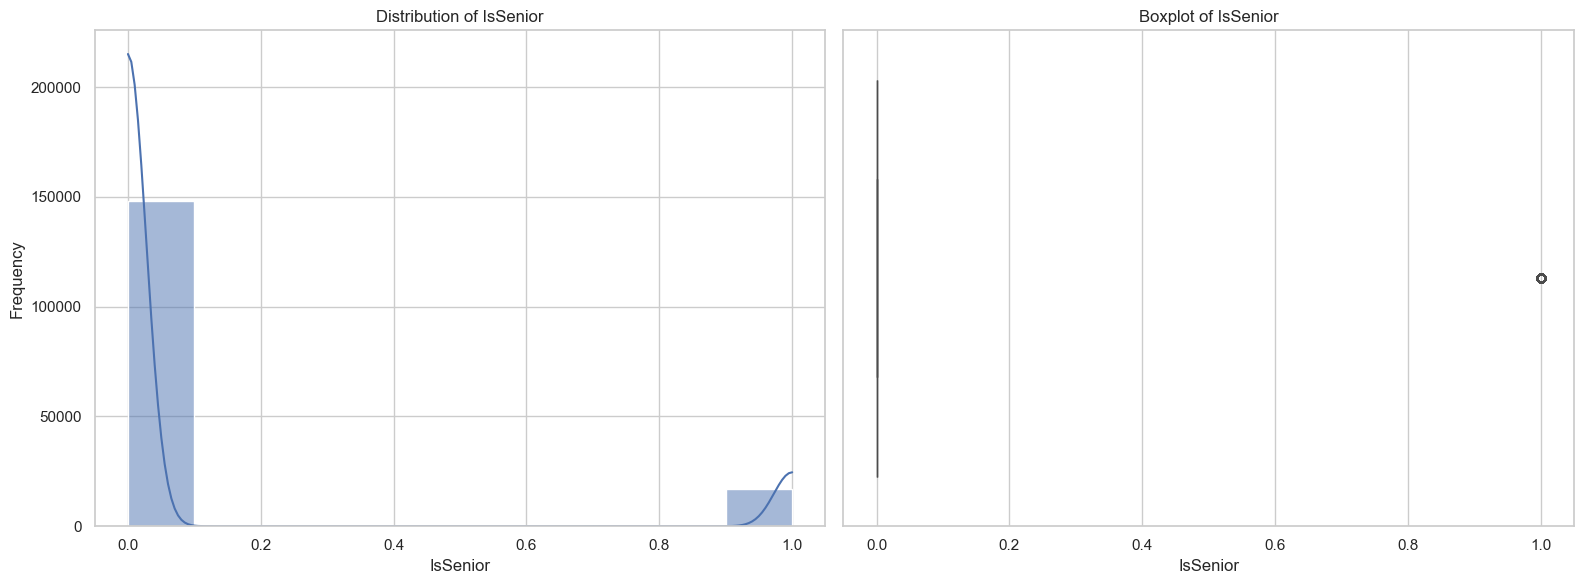

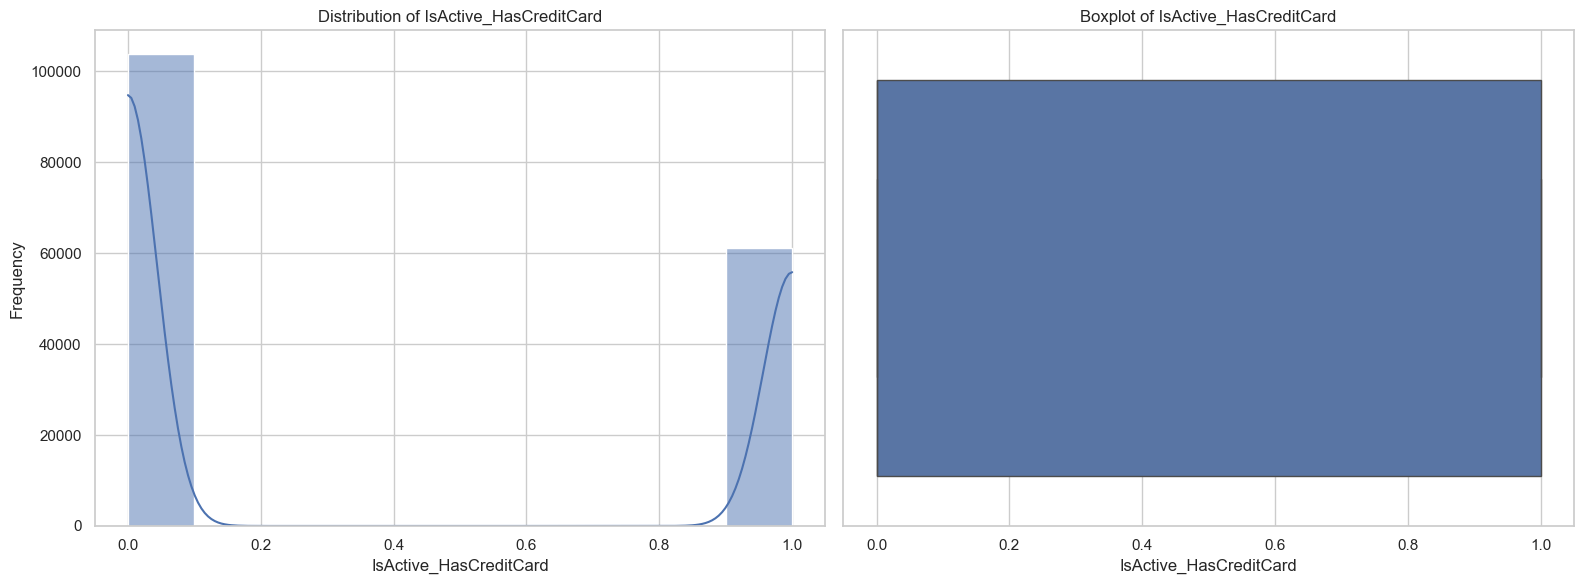

In [89]:
# Plotting data distributions and box plots for each feature
for column in train_fe.columns:  
    plt.figure(figsize=(16, 6))  

    # 绘制数据分布  
    plt.subplot(1, 2, 1)  
    sns.histplot(train_fe[column], kde=True, bins=10)  # 直方图和核密度估计  
    plt.title(f'Distribution of {column}')  
    plt.xlabel(column)  
    plt.ylabel('Frequency')  

    # 绘制箱线图  
    plt.subplot(1, 2, 2)  
    sns.boxplot(x=train_fe[column])  
    plt.title(f'Boxplot of {column}')  
    plt.xlabel(column)  

    plt.tight_layout()  # 自动调整子图间距  
    plt.show()

###### Observation:
we found that 'CreditScore','Balance','EstimatedSalary' these three continuum data features show a skewed distribution.
So let use the RobustScaler to do feature scaling.

Other discrete category features can be used directly with this MinMaxScaler.

In [188]:
train_ecd_scal = train_fe
test_ecd_scal = test_fe

In [189]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler
scaler = RobustScaler()
minmax = MinMaxScaler()

In [206]:
columns_to_minmax_scale = ['Age', 'Tenure', 'NumOfProducts','Age_band']
train_ecd_scal[columns_to_minmax_scale] = minmax.fit_transform(train_ecd_scal[columns_to_minmax_scale])
test_ecd_scal[columns_to_minmax_scale] = minmax.fit_transform(test_ecd_scal[columns_to_minmax_scale])
X_smote[columns_to_minmax_scale] = minmax.fit_transform(X_smote[columns_to_minmax_scale])

In [207]:
columns_to_RobustScaler = ['CreditScore','Balance','EstimatedSalary']
train_ecd_scal[columns_to_RobustScaler] = scaler.fit_transform(train_ecd_scal[columns_to_RobustScaler])
test_ecd_scal[columns_to_RobustScaler] = minmax.fit_transform(test_ecd_scal[columns_to_RobustScaler])
X_smote[columns_to_RobustScaler] = minmax.fit_transform(X_smote[columns_to_RobustScaler])

# 9. Modeling-XGBoost-Nonresample

Data Preparation

In [209]:
X = train_ecd_scal.drop(columns=['Exited'], axis=1)
y = train_ecd_scal['Exited']
test_ecd_scal

## 9.1 XGBoost

In XGBoost Hyperparameter "scale_pos_weight" helps to deal with the imbalanced data.

## 9.1.1 Cross-Validation for non-tuning

In [234]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict

def model_prediction(model, x, y, n_splits=3, random_state=42):
    training_score = []
    testing_score = []
    precission = []
    recall = []
    Roc_Auc_score = []
    f1_score_ = []
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    for train_index, test_index in skf.split(x, y):
        x_train, x_test = x.iloc[train_index], x.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model.fit(x_train, y_train)
        x_train_pred = model.predict(x_train)
        x_test_pred = model.predict(x_test)
        y_test_prob = model.predict_proba(x_test)[:, 1]

        a = accuracy_score(y_train, x_train_pred) * 100
        b = accuracy_score(y_test, x_test_pred) * 100
        c = precision_score(y_test, x_test_pred)
        d = recall_score(y_test, x_test_pred)
        e = roc_auc_score(y_test, y_test_prob)
        f = f1_score(y_test, x_test_pred)

        training_score.append(a)
        testing_score.append(b)
        precission.append(c)
        recall.append(d)
        Roc_Auc_score.append(e)
        f1_score_.append(f)

    print("\n------------------------------------------------------------------------")
    print(f"Mean Accuracy_Score of {model} model on Training Data is:", np.mean(training_score))
    print(f"Mean Accuracy_Score of {model} model on Testing Data is:", np.mean(testing_score))
    print(f"Mean Precision Score of {model} model is:", np.mean(precission))
    print(f"Mean Recall Score of {model} model is:", np.mean(recall))
    print(f"Mean ROC_AUC Score of {model} model is:", np.mean(Roc_Auc_score))
    print(f"Mean f1 Score of {model} model is:", np.mean(f1_score_))

    print("\n------------------------------------------------------------------------")
    print(f"Classification Report of {model} model is:")
    y_pred_all = cross_val_predict(model, x, y, cv=skf)
    print(classification_report(y, y_pred_all))

    print("\n------------------------------------------------------------------------")
    print(f"Confusion Matrix of {model} model is:")
    cm = confusion_matrix(y, y_pred_all)
    plt.figure(figsize=(8, 4))
    sns.heatmap(cm, annot=True, fmt="g", cmap="summer")
    plt.show()


------------------------------------------------------------------------
Mean Accuracy_Score of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) model on Training Data is: 88.32066973650247
Mean Accuracy_Score of XGBClassifier(base_score=None, booster=None, callbacks=None,
              co

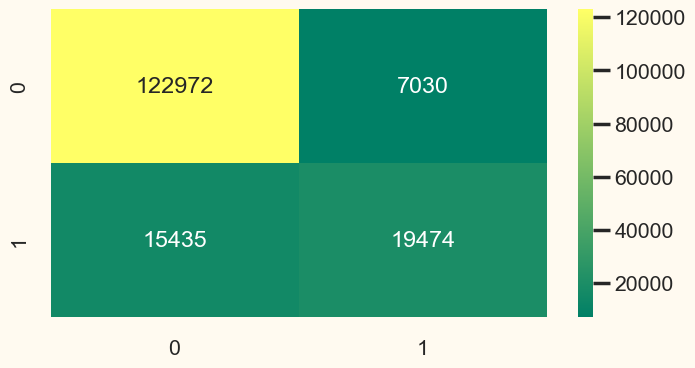

In [220]:
model_prediction(xgb.XGBClassifier(), X, y, n_splits=3, random_state=42)

##### Some Observations from above plot:
    from confusion matrix we can see that total of the 32533 people that did not leave, 30864 (94%) were correctly classified and from the total people that left the conpany, 8730 only 4850 (55%) were correctly classified.

    So we can see that our model is performing very good on exited=0 and it is performing very poorly on the other class exited=1.
    
    People who are leaving the bank will cost more to the bank so if our model successfully captures more of those people we can say that our model is performing well.

In XGBoost Hyperparameter scale_pos_weight helps to deal with the imbalanced data.

## 9.3 Hyperparameter Tuning and Cross-Validation

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=42, 
                                                    stratify=y)

3.5 Creating Baseline Model:

Now that we have splitted the data into train and test set sucessfully. Let's create a baseline model for our data. We will try to improve the model by Hyperparameter Tuning and Cross-Validation.
The Basic understanding of the parameteres that I have used here in model is given below:
1. Objective:

The two most popular classification objectives are:

binary:logistic - binary classification (the target contains only two classes, i.e., cat or dog)
multi:softprob - multi-class classification (more than two classes in the target, i.e., apple/orange/banana)
Our data has only 2 classes Exited=1 and Exited=0 so I am using binary:logistic as objective here.

2. Verobse: To know what is going on in the model train we set verbose as True.

3. Early Stopping Round:

When given an unnecessary number of boosting rounds, XGBoost starts to overfit and memorize the dataset. This, in turn, leads to validation performance drop because the model is memorizing instead of generalizing. early_stopping_rounds helps to prevent that.
If value of early_stopping_rounds is set to 10 then model will stop the training process if there is no major improvement in the evaluation parameters.
4. Evaluation Metric: The performance measure. For example, r2 for regression models, precision for classification models. I will be using auc (Area under curve) because it performs well with the imbalanced data.

5. Evaluation set: X_test and y_test both are used for the evaluation purpose.

### 9.3.1 GridSearchCV

#### Parameter

##### 1. Objective:
The two most popular classification objectives are:

    binary:logistic - binary classification (the target contains only two classes, i.e., cat or dog)
    multi:softprob - multi-class classification (more than two classes in the target, i.e., apple/orange/banana)

#### 9.3.1.1 Round 1

In [85]:
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.05, 0.01, 0.1],
    'gamma': [0, 0.25, 1.0],
    'reg_lambda': [0, 1.0, 10.0],
    'scale_pos_weight': [1, 3, 5]
}

optimal_parameters = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic',
                                seed=42),
    param_grid=param_grid,
    verbose=3,
    n_jobs=10,
    cv=3
)

optimal_parameters.fit(X,y)

print(optimal_parameters.best_params_)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
{'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 5, 'reg_lambda': 10.0, 'scale_pos_weight': 1}


#### 9.3.1.2 Round 2

In [90]:
param_grid = {
    'subsample': [0.3,0.5,0.7,0.9],
    'colsample_bytree': [0.3,0.5,0.7,0.9]
}

optimal_parameters = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic',
                                seed=42,
                                gamma=0.25,
                               learning_rate=0.1,
                               max_depth=5,
                               reg_lambda=10.0,
                               scale_pos_weight=1,),
    param_grid=param_grid,
    verbose=3,
    n_jobs=10,
    cv=3
)

optimal_parameters.fit(X,y)

print(optimal_parameters.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
{'colsample_bytree': 0.9, 'subsample': 0.3}


In [88]:
param_grid = {
    'subsample': [0.3,0.6,0.9],
    'colsample_bytree': [0.3,0.6,0.9]
}

optimal_parameters = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic',
                                seed=42),
    param_grid=param_grid,
    verbose=3,
    n_jobs=10,
    cv=3
)

optimal_parameters.fit(X,y)

print(optimal_parameters.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
{'colsample_bytree': 0.3, 'subsample': 0.9}


#### 9.3.1.3 Round 3

In [94]:
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.05, 0.01, 0.1],
    'gamma': [0, 0.25, 1.0],
    'reg_lambda': [0, 1.0, 10.0],
    'scale_pos_weight': [1, 3, 5]
}

optimal_parameters = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic',
                                seed=42,
                                subsample=0.9,
                                colsample_bytree=0.5),
    param_grid=param_grid,
    verbose=3,
    n_jobs=10,
    cv=3
)

optimal_parameters.fit(X,y)

print(optimal_parameters.best_params_)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
{'gamma': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'reg_lambda': 1.0, 'scale_pos_weight': 1}


#### 9.3.1.3 Round 3.1

In [95]:
param_grid = {
    'max_depth': [5, 7, 9],
    'learning_rate': [0.1, 0.5, 1],
    'gamma': [1.0, 1.5, 2]
}

optimal_parameters = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic',
                                seed=42,
                                reg_lambda = 1.0,
                                scale_pos_weight = 1,
                                subsample=0.9,
                                colsample_bytree=0.5),
    param_grid=param_grid,
    verbose=3,
    n_jobs=10,
    cv=3
)

optimal_parameters.fit(X,y)

print(optimal_parameters.best_params_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
{'gamma': 1.0, 'learning_rate': 0.1, 'max_depth': 5}


#### 9.3.1.4 Round 4

In [91]:
param_grid = {
    'max_depth': [5, 7, 9],
    'learning_rate': [0.1, 0.5, 1]
}

optimal_parameters = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic',
                                seed=42,
                                subsample=0.9,
                                colsample_bytree=0.3,
                                reg_lambda = 0,
                                scale_pos_weight=1,
                                gamma = 0),
    param_grid=param_grid,
    verbose=3,
    n_jobs=10,
    cv=3
)

optimal_parameters.fit(X,y)

print(optimal_parameters.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
{'learning_rate': 0.5, 'max_depth': 5}


### 9.3.2 Final Model

#### Parameter


##### 1. Objective:

    The two most popular classification objectives are:
    
    binary:logistic - binary classification (the target contains only two classes, i.e., cat or dog)
    multi:softprob - multi-class classification (more than two classes in the target, i.e., apple/orange/banana)
    Our data has only 2 classes Exited=1 and Exited=0 so I am using binary:logistic as objective here.

###### 2. Verobse: 
    To know what is going on in the model train we set verbose as True.

##### 3. Early Stopping Round:
    When given an unnecessary number of boosting rounds, XGBoost starts to overfit and memorize the dataset. This, in turn, leads to validation performance drop because the model is memorizing instead of generalizing. early_stopping_rounds helps to prevent that.
    If value of early_stopping_rounds is set to 10 then model will stop the training process if there is no major improvement in the evaluation parameters.

##### 4. Evaluation Metric: 
    The performance measure. For example, r2 for regression models, precision for classification models. I will be using auc (Area under curve) because it performs well with the imbalanced data.

##### 5. Evaluation set: 
    X_test and y_test both are used for the evaluation purpose.

In [105]:
clf_xgb_v1 = xgb.XGBClassifier(seed=42,
                               objective='binary:logistic',
                               subsample=0.9,
                                colsample_bytree=0.5,
                               gamma=1.0,
                               learning_rate=0.1,
                               max_depth=5,
                               reg_lambda=1.0,
                               scale_pos_weight=4,
                               early_stopping_rounds=10,
                              eval_metric='auc')

clf_xgb_v1.fit(X_train,
               y_train,
               verbose=True,
               eval_set=[(X_test,y_test)])

[0]	validation_0-auc:0.83749
[1]	validation_0-auc:0.83495
[2]	validation_0-auc:0.84281
[3]	validation_0-auc:0.86609
[4]	validation_0-auc:0.86686
[5]	validation_0-auc:0.86522
[6]	validation_0-auc:0.86652
[7]	validation_0-auc:0.86907
[8]	validation_0-auc:0.86798
[9]	validation_0-auc:0.86940
[10]	validation_0-auc:0.86840
[11]	validation_0-auc:0.87394
[12]	validation_0-auc:0.87503
[13]	validation_0-auc:0.87546
[14]	validation_0-auc:0.87563
[15]	validation_0-auc:0.87541
[16]	validation_0-auc:0.87845
[17]	validation_0-auc:0.88026
[18]	validation_0-auc:0.88232
[19]	validation_0-auc:0.88366
[20]	validation_0-auc:0.88372
[21]	validation_0-auc:0.88465
[22]	validation_0-auc:0.88429
[23]	validation_0-auc:0.88422
[24]	validation_0-auc:0.88431
[25]	validation_0-auc:0.88527
[26]	validation_0-auc:0.88585
[27]	validation_0-auc:0.88640
[28]	validation_0-auc:0.88695
[29]	validation_0-auc:0.88731
[30]	validation_0-auc:0.88756
[31]	validation_0-auc:0.88749
[32]	validation_0-auc:0.88773
[33]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=1.0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

              precision    recall  f1-score   support

           0       0.94      0.81      0.87     32501
           1       0.53      0.82      0.64      8727

    accuracy                           0.81     41228
   macro avg       0.74      0.81      0.76     41228
weighted avg       0.86      0.81      0.82     41228



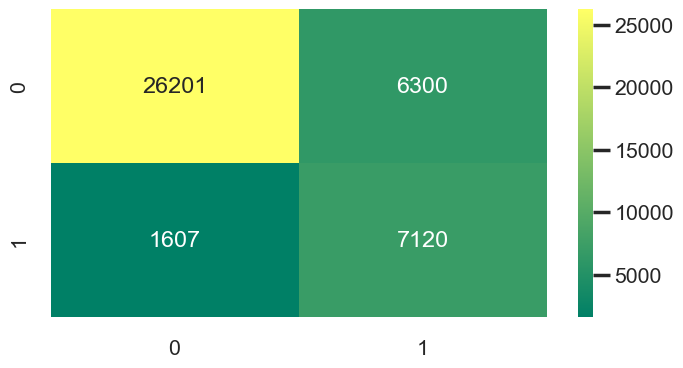

In [106]:
predictions_1 = clf_xgb_v1.predict(X_test)
print(classification_report(y_test, predictions_1))
cm = confusion_matrix(y_test, predictions_1)

plt.figure(figsize=(8, 4))
sns.heatmap(cm, annot=True, fmt="g", cmap="summer")
plt.show()

# 11. SMOTE

In [223]:
np.array(y_smote).shape

(260004,)

In [221]:
y_smote.shape

(260004,)

### 11.1 RandomForest for SMOTE


------------------------------------------------------------------------
Mean Accuracy_Score of RandomForestClassifier() model on Training Data is: 99.98461562129815
Mean Accuracy_Score of RandomForestClassifier() model on Testing Data is: 89.65246688512485
Mean Precision Score of RandomForestClassifier() model is: 0.8959893215280309
Mean Recall Score of RandomForestClassifier() model is: 0.8972015815141305
Mean ROC_AUC Score of RandomForestClassifier() model is: 0.9596894833212968
Mean f1 Score of RandomForestClassifier() model is: 0.8965926939960212

------------------------------------------------------------------------
Classification Report of RandomForestClassifier() model is:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90    130002
           1       0.90      0.90      0.90    130002

    accuracy                           0.90    260004
   macro avg       0.90      0.90      0.90    260004
weighted avg       0.90      0.90  

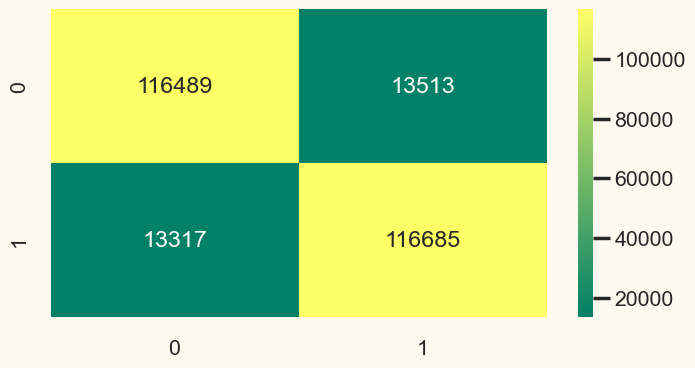

In [238]:
clf_rfc = RandomForestClassifier()
model_prediction(clf_rfc, X_smote, y_smote, n_splits=3, random_state=42)


### 11.2 XGBoost for SMOTE Nontuning


------------------------------------------------------------------------
Mean Accuracy_Score of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) model on Training Data is: 90.95110075229611
Mean Accuracy_Score of XGBClassifier(base_score=None, booster=None, callbacks=None,
              co

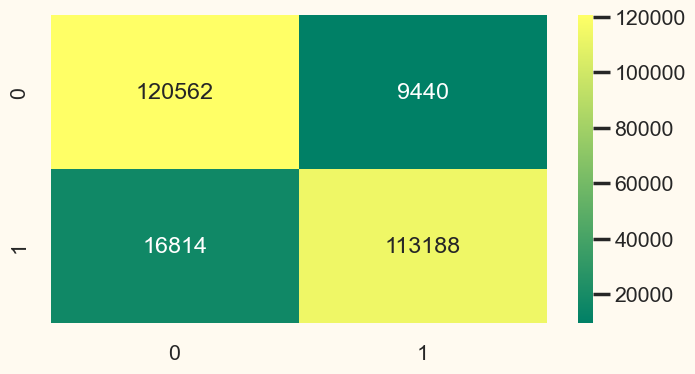

In [235]:
clf_xgb = xgb.XGBClassifier()
model_prediction(clf_xgb, X_smote, y_smote)

### 11.3 AdaBoost for SMOTE


------------------------------------------------------------------------
Mean Accuracy_Score of AdaBoostClassifier() model on Training Data is: 83.93313179797234
Mean Accuracy_Score of AdaBoostClassifier() model on Testing Data is: 83.90793987784804
Mean Precision Score of AdaBoostClassifier() model is: 0.8342496269318888
Mean Recall Score of AdaBoostClassifier() model is: 0.8463177489577083
Mean ROC_AUC Score of AdaBoostClassifier() model is: 0.917712752851933
Mean f1 Score of AdaBoostClassifier() model is: 0.8402351773787209

------------------------------------------------------------------------
Classification Report of AdaBoostClassifier() model is:
              precision    recall  f1-score   support

           0       0.84      0.83      0.84    130002
           1       0.83      0.85      0.84    130002

    accuracy                           0.84    260004
   macro avg       0.84      0.84      0.84    260004
weighted avg       0.84      0.84      0.84    260004


--------

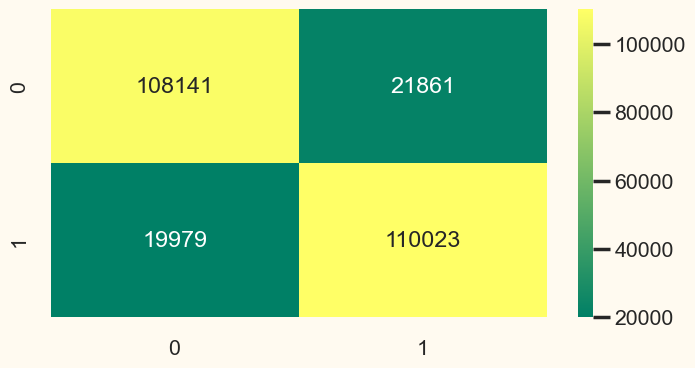

In [255]:
clf_adb = AdaBoostClassifier()
model_prediction(clf_adb, X_smote, y_smote)

### 11.4 GradientBoost for SMOTE


------------------------------------------------------------------------
Mean Accuracy_Score of GradientBoostingClassifier() model on Training Data is: 87.52615344379318
Mean Accuracy_Score of GradientBoostingClassifier() model on Testing Data is: 87.4625005769142
Mean Precision Score of GradientBoostingClassifier() model is: 0.8815290266819117
Mean Recall Score of GradientBoostingClassifier() model is: 0.8655789910924447
Mean ROC_AUC Score of GradientBoostingClassifier() model is: 0.9465741254537555
Mean f1 Score of GradientBoostingClassifier() model is: 0.8734798760788319

------------------------------------------------------------------------
Classification Report of GradientBoostingClassifier() model is:
              precision    recall  f1-score   support

           0       0.87      0.88      0.88    130002
           1       0.88      0.87      0.87    130002

    accuracy                           0.87    260004
   macro avg       0.87      0.87      0.87    260004
weighted

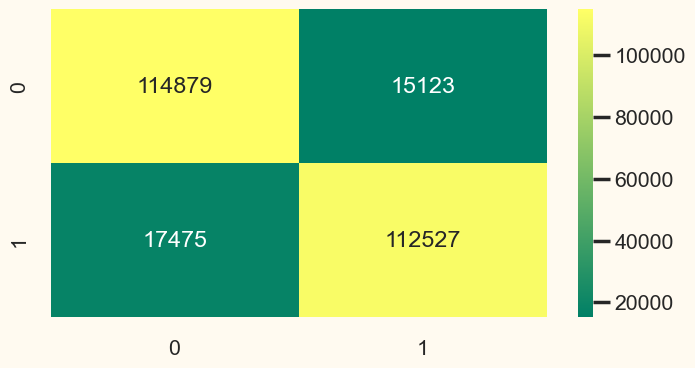

In [246]:
clf_gdb = GradientBoostingClassifier()
model_prediction(clf_gdb, X_smote, y_smote)

# 12. Feature Importance

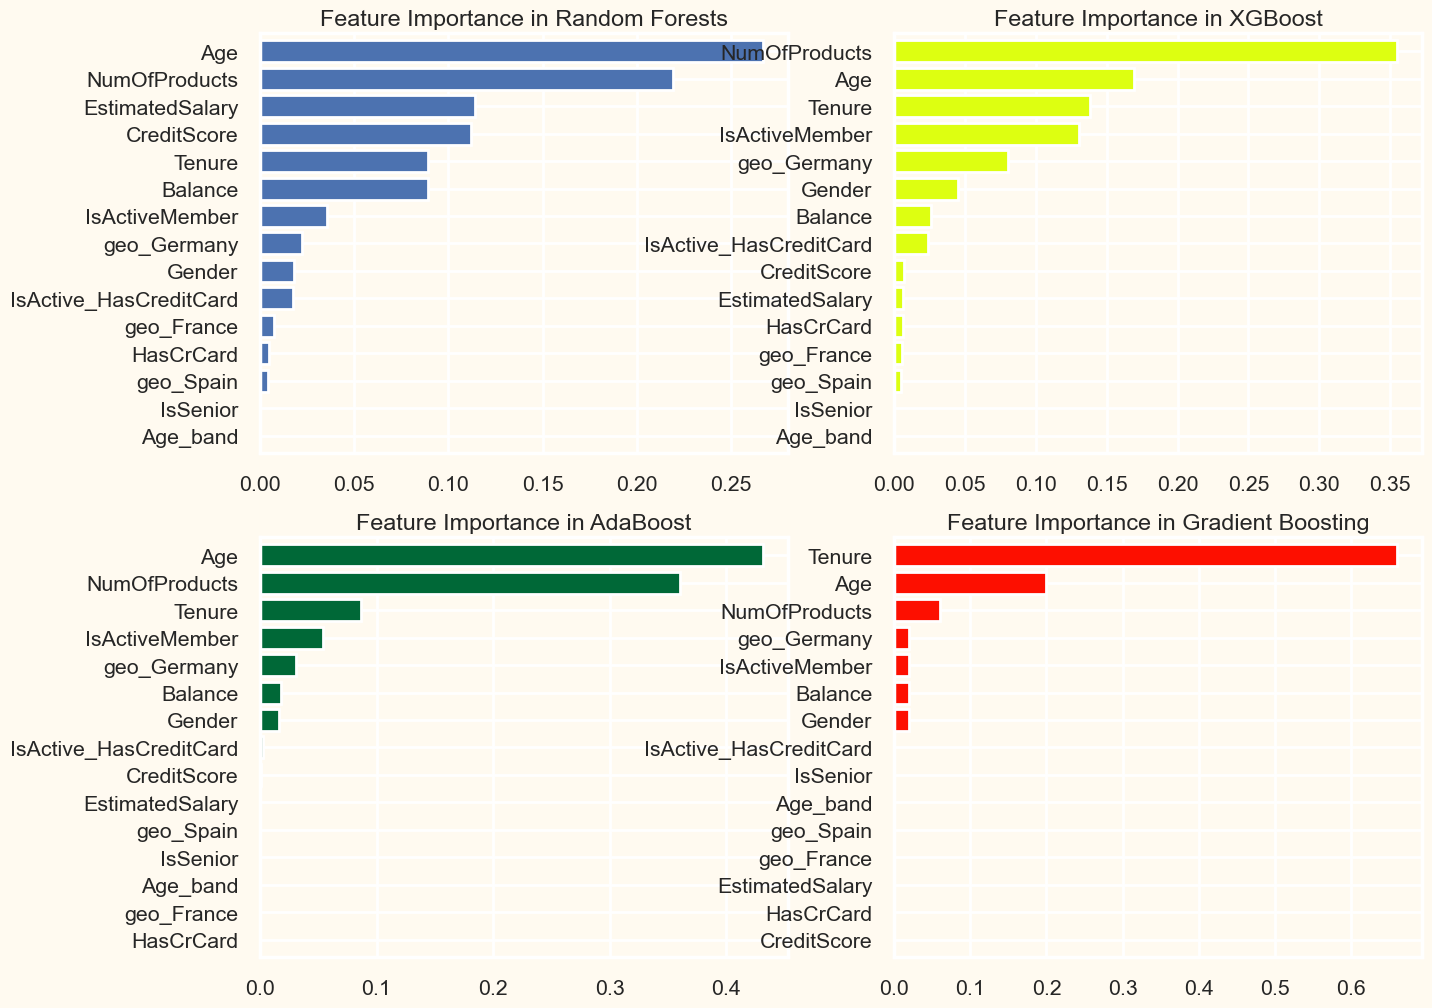

In [256]:
f,ax=plt.subplots(2,2,figsize=(15,12))
pd.Series(clf_rfc.feature_importances_,X_smote.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[0,0])
ax[0,0].set_title('Feature Importance in Random Forests')
pd.Series(clf_xgb.feature_importances_,X_smote.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[0,1],color='#ddff11')
ax[0,1].set_title('Feature Importance in XGBoost')
pd.Series(clf_adb.feature_importances_,X_smote.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[1,1],color='#FD0F00')
ax[1,0].set_title('Feature Importance in AdaBoost')
pd.Series(clf_gdb.feature_importances_,X_smote.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[1,0],cmap='RdYlGn_r')
ax[1,1].set_title('Feature Importance in Gradient Boosting')
plt.show()

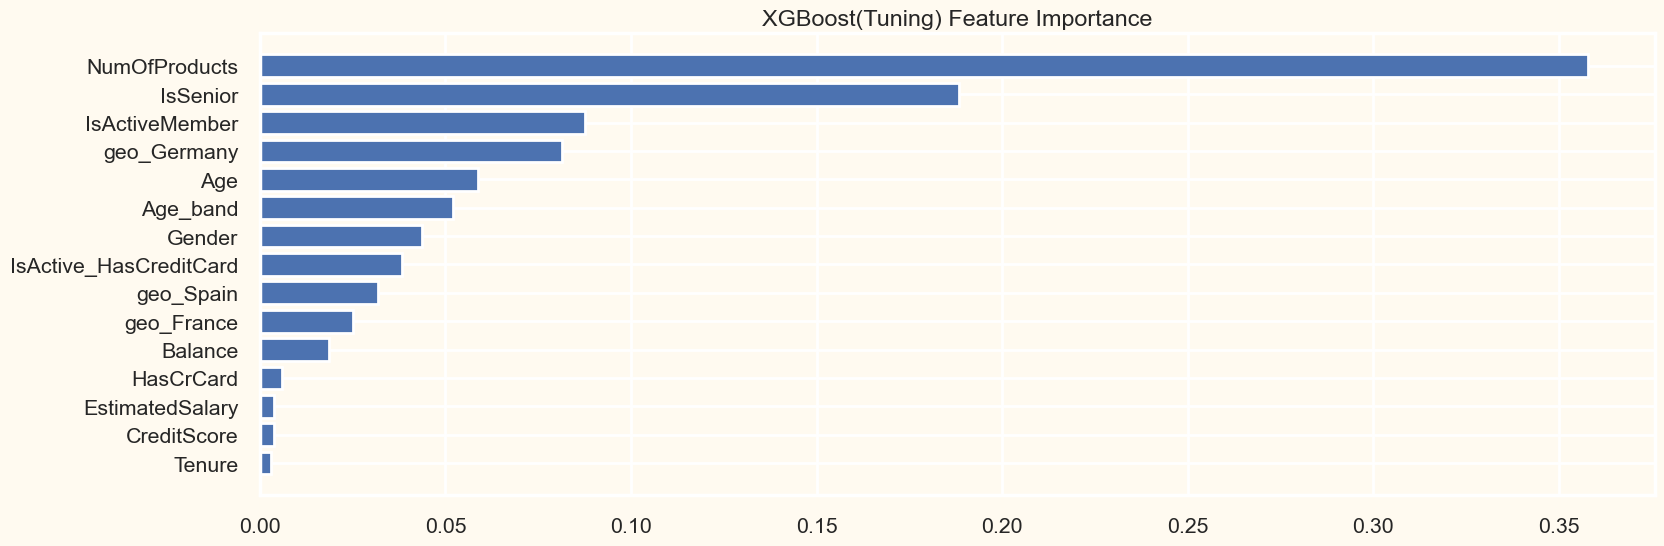

In [257]:
feature_importance = clf_xgb_v1.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(18, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('XGBoost(Tuning) Feature Importance')
plt.show()

We can see the important features for various classifiers like RandomForests, XGBoost,etc.

##### Observations:
xxx